# Modules, colors, and functions

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
  return false;
}

<IPython.core.display.Javascript object>

In [40]:
# Modules
import scipy as sp
from scipy import sparse, signal, stats
from astropy import convolution as conv
import numpy as np
from numpy.fft import fft, ifft
import matplotlib.pyplot as plt
from matplotlib import colors as clrs
import pandas as pd 
import time
import datetime
import calendar
import seaborn as sns
from copy import deepcopy

import multiprocessing as mp
from multiprocessing.dummy import Pool as ThreadPool

%matplotlib inline 

import sys
sys.path.insert(1, r'functions')  # add to pythonpath
from detect_peaks import detect_peaks


# Color definitions
ClrS = (0.74, 0.00, 0.00)
ClrN = (0.20, 0.56, 1.00)

Clr = [(0.00, 0.00, 0.00),
      (0.31, 0.24, 0.00),
      (0.43, 0.16, 0.49),
      (0.32, 0.70, 0.30),
      (0.45, 0.70, 0.90),
      (1.00, 0.82, 0.67)]

# Font Size

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size'   : 21}

plt.rc('font', **font)

# Histogram and scatter plot
def plotHistSqrtSSN(ax, calRefT, calObsT, Th, maxN, SqrtF):
    
    # Number of bins to use
    Nbins = maxN
    
    #Edges and Centers
    edges = np.arange(0,np.ceil(maxN)+np.round(maxN*0.25), (np.ceil(maxN))/Nbins) - (np.ceil(maxN))/Nbins/2
    centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2    
    
    # Applying Sqrt + 1
    if SqrtF:        
        maxN = np.sqrt(maxN)
        calRefT = np.sqrt(calRefT+1)
        calObsT = np.sqrt(calObsT+1)
        
        #Edges and Centers
        edges = np.arange(1,np.ceil(maxN)*1.05, (np.ceil(maxN))/Nbins) - (np.ceil(maxN))/Nbins/2
        centers = (edges[1:edges.shape[0]] + edges[0:edges.shape[0]-1])/2 
    
    # Average group number 
    ax.hist2d(calObsT, calRefT, bins=edges, cmap=plt.cm.magma_r,cmin=1)
    
    hist, xedges, yedges = np.histogram2d(calObsT, calRefT, bins=edges)
    alphaY = np.sum(hist,axis=1)/np.max(np.sum(hist,axis=1))*0.95+0.05
    
    # Calculating Quantities for plot and plot centers in Y
    Ymedian = centers*np.nan
    for i in range(0, centers.shape[0]):
        ypoints = calRefT[np.logical_and(calObsT>=edges[i], calObsT<=edges[i+1])]
        if ypoints.shape[0]>0:
            Ymedian[i] = np.nanmedian(ypoints)
            pecentilesy = np.abs(np.percentile(ypoints,np.array([15,85]), interpolation = 'linear')-Ymedian[i])
        
            xpoints = calObsT[np.logical_and(calRefT>=(Ymedian[i]-(np.ceil(maxN))/Nbins/2), calRefT<=(Ymedian[i]+(np.ceil(maxN))/Nbins/2))]
        
            if xpoints.shape[0]>0:
                pecentilesx = np.abs(np.percentile(xpoints,np.array([15,85]), interpolation = 'linear')-centers[i])
            else:
                pecentilesx = pecentilesy*0
        
            ax.errorbar(centers[i], Ymedian[i], yerr = np.expand_dims(pecentilesy,axis = 1), xerr = np.expand_dims(pecentilesx,axis = 1), color='k', zorder=11, alpha=alphaY[i])
            ax.scatter(centers[i], Ymedian[i], color='w', edgecolor='k', s=100, linewidths = 3, zorder=11, alpha=alphaY[i])

    # Calculating quantities for assessment
    y = Ymedian
    x = centers

    x = x[np.isfinite(y)]
    y = y[np.isfinite(y)]

    # R squared
    yMean = np.mean(y)    
    SStot = np.sum(np.power(y-yMean,2)) 
    SSreg = np.sum(np.power(y-x,2))
    rSq   = (1 - SSreg/SStot)

    # Mean Residual
    mRes = np.mean(x-y)
    
    # Mean Relative Residual
    mRRes = np.mean(np.divide(x[x>0]-y[x>0],x[x>0]))    
    
    ax.plot(edges, edges, '--'
             , color = Clr[4], linewidth = 3)

    ax.text(0.5, 0.95,'$R^2M$=' + str(np.round(rSq,decimals=2)) + ' $MR$=' + str(np.round(mRes,decimals=2)) + ' $MRR$=' + str(int(np.round(mRRes*100,decimals=0))) + '% $Th$=' + str(Th), horizontalalignment='center', verticalalignment='center',transform=ax.transAxes)

    # Axes properties
    
    if SqrtF: 
        ax.set_xlabel('sqrt(GN+1) for ' + NamObs.capitalize())
        ax.set_ylabel('sqrt(GN+1) for reference')
    else:
        ax.set_xlabel('GN for ' + NamObs.capitalize())
        ax.set_ylabel('GN for reference observer')
        
    ax.set_xticks(np.arange(centers[0],np.ceil(centers[-1]), np.floor((np.ceil(centers[-1])-centers[0])/8)+1 ))
    ax.set_yticks(np.arange(centers[0],np.ceil(centers[-1]), np.floor((np.ceil(centers[-1])-centers[0])/8)+1 ))

        
# Histogram Outline
def histOutline(dataIn, *args, **kwargs):
    (histIn, binsIn) = np.histogram(dataIn, *args, **kwargs)

    stepSize = binsIn[1] - binsIn[0]

    bins = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    data = np.zeros(len(binsIn)*2 + 2, dtype=np.float)
    for bb in range(len(binsIn)):
        bins[2*bb + 1] = binsIn[bb]
        bins[2*bb + 2] = binsIn[bb] + stepSize
        if bb < len(histIn):
            data[2*bb + 1] = histIn[bb]
            data[2*bb + 2] = histIn[bb]

    bins[0] = bins[1]
    bins[-1] = bins[-2]
    data[0] = 0
    data[-1] = 0

    return (bins, data)

# Reading SILSO's total sunspot number
We use the current series to separate individual cycles from minimum to minimum. We also identify all the minima present in the reference data, removing the first two minima to isolate potential drifts and systematic errors during the beginning of the RGO era.

In [ ]:
SILSO_Sn = pd.read_csv('input_data/SN_m_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
SILSO_Sn['DAY'] = 15+SILSO_Sn['MONTH']*0
SILSO_Sn['ORDINAL'] = SILSO_Sn.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
print(SILSO_Sn)

In [4]:
SILSO_Sn = pd.read_csv('input_data/SN_m_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
SILSO_Sn_d = pd.read_csv('input_data/SN_d_tot_V2.0.csv', quotechar = '"', encoding = 'ansi', header = 0)
SILSO_Sn_d['MONTHSN']=SILSO_Sn_d['DAILYSN']

SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'MONTHSN'] = np.interp(SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']<0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'FRACYEAR'],
                                                              SILSO_Sn_d.loc[SILSO_Sn_d['DAILYSN']>=0,'DAILYSN'])

SILSO_Sn_d['DAILYSN'] = SILSO_Sn_d['DAILYSN'].astype(float)

# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(365)
SILSO_Sn_d['AVGSNd']  = conv.convolve(SILSO_Sn_d['DAILYSN'].values,Gss_1D_ker)

# # Smoothing 
swin = 8 
window = signal.gaussian(M=swin*6, std=swin)
window /= window.sum()
SILSO_Sn['MSMOOTH'] = np.convolve(SILSO_Sn['MMEAN'], window, mode='same') 

# # Finding maxima and minima
pkMax = detect_peaks(SILSO_Sn['MSMOOTH'], mpd=5)
pkMin = detect_peaks(-SILSO_Sn['MSMOOTH'], mpd=5)

SIL_max = SILSO_Sn.loc[pkMax, 'MSMOOTH'].values 
SIL_maxT = SILSO_Sn.loc[pkMax, 'FRACYEAR'].values 

# #the same for minimum
SIL_min = SILSO_Sn.loc[pkMin, 'MSMOOTH'].values
SIL_minT = SILSO_Sn.loc[pkMin, 'FRACYEAR'].values


# Reading Reference data
We use a reduced version of the RGO and Debrecen data as provided by the Heliophysical Observatory, Debrecen . Supplemented during cycle 24 with observations by the Kidslovodsk Mountain Astronomical Station. It has been recast as a table where each corresponds to a single day and the areas of each group for a given day are stored as columns.

We add three more columns to the data:

1. ORDINAL:  number of days after (0001,01,01).
2. FRACYEAR: Fractional year for plotting.
3. SN(v_2.0): daily sunspot number index values 

In [ ]:
REF_Dat = pd.read_csv('input_data/SC_SP_RG_DB_KM_group_areas_by_day.csv', quotechar = '"', encoding = 'ansi',header = 0)
REF_Dat['ORDINAL'] = REF_Dat.apply(lambda x: datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal(),axis=1)
REF_Dat['FRACYEAR'] = REF_Dat.apply(lambda x: x['YEAR'].astype(int)
                                        + (  datetime.date(x['YEAR'].astype(int),x['MONTH'].astype(int),x['DAY'].astype(int)).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                                        / (  datetime.date(x['YEAR'].astype(int)+1,1,1).toordinal()
                                           - datetime.date(x['YEAR'].astype(int),1,1).toordinal() )
                              ,axis=1)


# Turning reference areas into number of groups
REF_Grp = REF_Dat[['FRACYEAR','ORDINAL','YEAR','MONTH','DAY']].copy()
REF_Grp['GROUPS'] = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-2],0) ,axis = 1)
REF_Grp['GROUPS'] = REF_Grp['GROUPS'].astype(float)
REF_Grp.loc[np.isnan(REF_Dat['AREA1']), 'GROUPS'] = np.nan

# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(75)
REF_Grp['AVGROUPS']  = conv.convolve(REF_Grp['GROUPS'].values,Gss_1D_ker)


# # max and min amplitudes and dates for RGO
# # Identify minima covered by the reference data
REF_min = SIL_min[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]
REF_minT = SIL_minT[np.logical_and(SIL_minT<=np.max(REF_Dat['FRACYEAR']), SIL_minT>=np.min(REF_Dat['FRACYEAR']))]
# #print(REF_minT)

# # Identify maxima covered by the reference data
REF_max = SIL_max[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]
REF_maxT = SIL_maxT[np.logical_and(SIL_maxT<=np.max(REF_Dat['FRACYEAR']), SIL_maxT>=np.min(REF_Dat['FRACYEAR']))]


# Reading observations and observers

The files used were downloaded from [SILSO's Group Number page](http://www.sidc.be/silso/groupnumberv3).  The current version used is JV_V1-12, but turned into a .csv file.  The original file contains leap years that should not be there.  February 29th for those years were removed by hand (1700, 1800, 1900).

## Reading observations

We recast the number of groups as a float so that we can use NaNs for days with missing observations.

In [ ]:
GN_Dat = pd.read_csv('input_data/GNObservations_JV_V1.22.csv', quotechar = '"', encoding = 'ansi',header = 15)
GN_Dat['GROUPS'] = GN_Dat['GROUPS'].astype(float)

In [ ]:
print(GN_Dat)

# Reading observers
We create a variable to store each unique observer. NOTE THAT CURRENTLY EACH STATION HAS ONLY ONE OBSERVER SO WE DO ALL OUR LOGICAL OPERATIONS USING THE 'STATION' FIELD.

We also remove the '0' station which indicates a day without observations.

The print statement on this cell can be use for reference as it shows the station number associated with each observer.

In [ ]:
GN_Obs = pd.read_csv('input_data/GNObservers_JV_V1.22.csv', quotechar = '"', encoding = 'ansi')
print(GN_Obs[['INITIAL','FINAL','STATION','OBSERVER','TOT.OBS']].to_string())

UnObs = sp.unique(GN_Dat.STATION)
UnObs = UnObs[UnObs>0]

# Processing observer
This cell picks the observer that will be calibrated to REF. Some interesting observers are:

Spörer: 318 (lots of missing zeros)
Leppig: 324 (short and consistent, but with lots of missing days)
Wolfer: 338 (long and dense)
It is interesting to see if the time optimization can get the proper time accurately. Some observers that do:

Moye: 412 (1 cycle)
Broger: 370 (4 cycles)
Some that don't

Woinoff: 376 (2 cycles, very strong yearly variation)
Other long observers with overlap are:

Sykora: 366
Guillaume: 386
Stempell: 389 (lots of gaps)
Koyama: 445
National astron. ob. Japan: 447
Observations for the chosen observer are filled with NaNs for days without observations.

In [ ]:
# Observer Station Number
CalObs = 592
NamObs = GN_Obs['OBSERVER'].values[GN_Obs['STATION'].values==CalObs]
NamObs = NamObs[0]
NamObs = NamObs[0:NamObs.find(',')]

# Picking observations
ObsDat = GN_Dat[GN_Dat.STATION == CalObs].copy()

# Finding missing days
ObsInt  = np.arange(np.min(ObsDat['ORDINAL']), np.max(ObsDat['ORDINAL']+1))
MisDays =  np.logical_not(sp.in1d(ObsInt, ObsDat['ORDINAL'] ))

# Creating dataframe with NaNs for days without observations
year  = np.array(list(map(lambda x: datetime.date.fromordinal(x).year, ObsInt[MisDays])))
month = np.array(list(map(lambda x: datetime.date.fromordinal(x).month, ObsInt[MisDays])))
day   = np.array(list(map(lambda x: datetime.date.fromordinal(x).day, ObsInt[MisDays])))

station  = day*0+CalObs
observer = day*0+1
groups   = day*np.nan

fractyear = np.array(list(map(lambda year, month, day : year + (  datetime.date(year, month , day).toordinal()
                                            - datetime.date(year,1,1).toordinal() )
                                            / (  datetime.date(year+1,1,1).toordinal()
                                            - datetime.date(year,1,1).toordinal() ), year, month, day)))

NoObs = pd.DataFrame(np.column_stack((year, month, day, ObsInt[MisDays], station, observer, groups, fractyear)), columns = oldObsDat.columns.values)

# Append dataframe with missing days
ObsDat = ObsDat.append(NoObs,ignore_index=True)

# Recast using original data types
origType = GN_Dat.dtypes.to_dict()
ObsDat = ObsDat.apply(lambda x: x.astype(origType[x.name]))

# Sorting according to date
ObsDat = ObsDat.sort_values('ORDINAL').reset_index(drop=True)


In [ ]:
# Final data for RGO and given observer
cond1=pd.merge(SILSO_Sn_d, ObsDat, on=['YEAR', 'MONTH', 'DAY'], how='inner')
cond2=pd.merge(SILSO_Sn_d, REF_Grp, on=['YEAR', 'MONTH', 'DAY'], how='inner')

ObsDat=ObsDat.join(cond1['AVGSNd'])
REF_Grp=REF_Grp.join(cond2['AVGSNd'])
print(ObsDat)
print(REF_Grp)



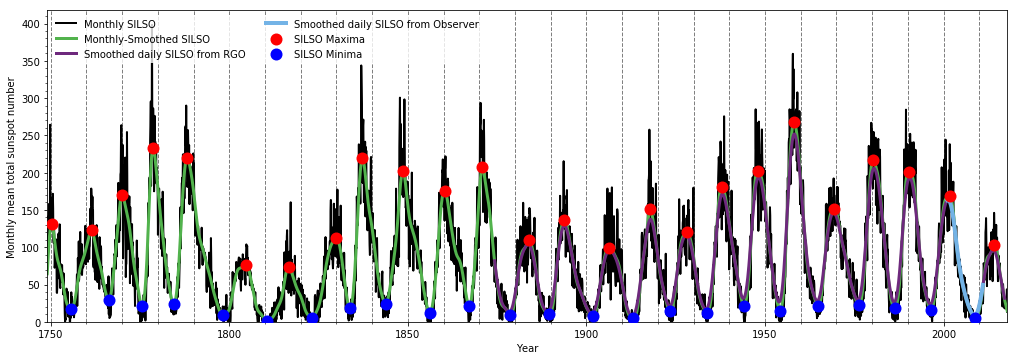

In [11]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300   # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Average group number 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MMEAN'], color = Clr[0], linewidth = 2) 
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MSMOOTH'], color = Clr[3], linewidth = 3) 
ax1.scatter(SIL_maxT, SIL_max, color='r', edgecolor='r', alpha = 1, s=100, linewidths = 2, zorder=10) 
ax1.scatter(SIL_minT, SIL_min, color='b', edgecolor='b', alpha = 1, s=100, linewidths = 2, zorder=10) 

ax1.plot(REF_Grp['FRACYEAR'], REF_Grp['AVGSNd'], color = Clr[2], linewidth = 3) 
ax1.plot(ObsDat['FRACYEAR'], ObsDat['AVGSNd'], color = Clr[4], linewidth = 4) 

ax1.legend(['Monthly SILSO','Monthly-Smoothed SILSO','Smoothed daily SILSO from RGO','Smoothed daily SILSO from Observer','SILSO Maxima', 'SILSO Minima','Extrema in Reference'], loc = 'upper left', ncol = 2, frameon = True, edgecolor = 'none')

# Axes properties
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly mean total sunspot number')
ax1.set_xlim(left = np.min(SILSO_Sn['FRACYEAR']), right = np.max(SILSO_Sn['FRACYEAR']))
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.minorticks_on()
ax1.set_ylim(bottom = 0);

## Recasting observations into equal intervals of specified duration¶
To simplify and speedup the analysis we segment the observational interval using "months" of arbitrary length. This allows us to reshape our time series into a matrix and perform matrix-vector operations that are much faster than for loops.

Only an integer amount of "months" is used in order to make the reshaping operation possible.

In [12]:
# Number of days per "month"
MoLngt = 30

# OBSERVER
# Selecting the maximum integer amount of "months" out of the original data
grpsOb = ObsDat['GROUPS'].values
grpsOb = grpsOb[0:np.int(grpsOb.shape[0]/MoLngt)*MoLngt] 

ordOb = ObsDat['ORDINAL'].values
ordOb = ordOb[0:np.int(ordOb.shape[0]/MoLngt)*MoLngt]

yrOb = ObsDat['FRACYEAR'].values
yrOb = yrOb[0:np.int(yrOb.shape[0]/MoLngt)*MoLngt]

SNdOb = ObsDat['AVGSNd'].values
SNdOb = SNdOb[0:np.int(SNdOb.shape[0]/MoLngt)*MoLngt]

# Reshaping
grpsOb = grpsOb.reshape((-1,MoLngt))
ordOb  = ordOb.reshape((-1,MoLngt))
yrOb   = yrOb.reshape((-1,MoLngt))
SNdOb  = SNdOb.reshape((-1,MoLngt))

# Calculating number of days with observations and number of days with groups

In [13]:
# OBSERVER

# Minimum fraction of observed days for an interval to be considered useful
minObD = 0.33;

# Number of days with observations
obsOb = np.sum(np.isfinite(grpsOb),axis=1)

# Number of days with groups
grpOb = np.sum(np.greater(grpsOb,0),axis=1)

# Average number of groups
Gss_1D_ker = conv.Gaussian1DKernel(2)
AvGrpOb = conv.convolve(np.nanmean(grpsOb,axis=1),Gss_1D_ker)
SdGrpOb = np.nanstd(grpsOb,axis=1)

#Average of sunspot number
AvSNdOb = np.nanmean(SNdOb,axis=1)
SdSNdOb = np.nanstd(SNdOb,axis=1)

# Interval edges for plotting
fyr1Ob = np.min(yrOb,axis=1)
fyr2Ob = np.max(yrOb,axis=1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in greater
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


## Breaking Observer Period into rising (decaying) Intervals

We break the observational period into cycles going from minimum to maximum, and maximum to minumum, in order to ease the capability of the algorithm to find the best matches during the reference era.
Furthermore, for each rising and decaying interval, we differenciate between low, middle, and high solar activity in order to calculate the active day fraction.

In [14]:
# Minimum ratio of valid "months" for a Min-Max Max-Min interval to be considered useful
vldIntThr = 0.33

# Finding internal endpoints and centers of SILSO

# Assinging max (1) and min (-1) labels to endpoints
maxPointsS = np.expand_dims(SIL_maxT,1) 
maxPointsS = np.concatenate((maxPointsS,maxPointsS*0+1),axis=1)

minPointsS = np.expand_dims(SIL_minT,1)
minPointsS = np.concatenate((minPointsS,minPointsS*0-1),axis=1)

# Creating endpoints matrix
endPointsS = np.append(maxPointsS,minPointsS,axis=0)
# Sorting endpoints
endPointsS = endPointsS[endPointsS[:,0].argsort()]

# Finding centers and classifying them as rising (1) and decaying (-1)
cenPointsS = (endPointsS[1:endPointsS.shape[0],:]+endPointsS[0:endPointsS.shape[0]-1,:])/2 
cenPointsS[:,1] = endPointsS[1:endPointsS.shape[0],1]

# Finding internal endpoints and centers of Reference
endPointsR = endPointsS[np.logical_and(endPointsS[:,0]>np.min(REF_Dat['FRACYEAR']),endPointsS[:,0]<np.max(REF_Dat['FRACYEAR'])),:]
cenPointsR = (endPointsR[1:endPointsR.shape[0],:]+endPointsR[0:endPointsR.shape[0]-1,:])/2
cenPointsR[:,1] = endPointsR[1:endPointsR.shape[0],1]

# Finding internal endpoints and centers of Observer Intervals are included if their center is covered by the observer

# Defining boolean array of valid centers
validCen = np.logical_and(cenPointsS[:,0]>np.min(yrOb),cenPointsS[:,0]<np.max(yrOb)); 

# Adding a True on the index prior to the first center to include the bracketing point
validCen[0:validCen.shape[0]-2] = np.logical_or(validCen[0:validCen.shape[0]-2], validCen[1:validCen.shape[0]-1])

# Adding a False at the beggining to account for the difference in size
validCen = np.insert(validCen, 0, False) 

# Defining arrays
endPoints = endPointsS[validCen,:] 
cenPoints = (endPoints[1:endPoints.shape[0],:]+endPoints[0:endPoints.shape[0]-1,:])/2 
cenPoints[:,1] = endPoints[1:endPoints.shape[0],1] 


# Identification of Min-Max Max-Min intervals with enough valid "months"
vldIntr = np.zeros(cenPoints.shape[0], dtype=bool) 

for siInx in range(0,cenPoints.shape[0]):
    
    # Redefining endpoints if interval is partial
    if endPoints[siInx, 0] < np.min(ObsDat['FRACYEAR']): 
        print('Redefining left endpoint')
        endPoints[siInx, 0] = np.min(ObsDat['FRACYEAR'])
        cenPoints[siInx, 0] = (endPoints[siInx, 0]+endPoints[siInx+1, 0])/2
        
    if endPoints[siInx+1, 0] > np.max(ObsDat['FRACYEAR']):
        print('Redefining right endpoint')
        endPoints[siInx+1, 0] = np.max(ObsDat['FRACYEAR'])
        cenPoints[siInx, 0] = (endPoints[siInx, 0]+endPoints[siInx+1, 0])/2
    
    print('Center:',np.round(cenPoints[siInx, 0],2), 'Edges:', np.round(endPoints[siInx, 0],2), np.round(endPoints[siInx+1, 0],2))
    
    # Selecting interval
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy() 
    
    # Selecting the maximum integer amount of "months" out of the original data
    TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()

    # Reshaping into "months"
    TgrpsOb = TgrpsOb.reshape((-1,MoLngt))            

    # Number of days with observations
    ODObs = np.sum(np.isfinite(TgrpsOb),axis=1)
    
    if np.sum(ODObs/MoLngt>=minObD)/ODObs.shape[0]>=vldIntThr: 
        # Marking interval as valid
        vldIntr[siInx] = True
        print('Valid interval. Proportion of valid months: ', np.round(np.sum(ODObs/MoLngt>=minObD)/ODObs.shape[0],2))
        
    else:
        print('INVALID interval. Proportion of valid months: ', np.round(np.sum(ODObs/MoLngt>=minObD)/ODObs.shape[0],2))
        
    print(' ')
        
print(str(np.sum(vldIntr)) + '/' + str(vldIntr.shape[0]) + ' valid intervals')

if np.sum(vldIntr)==0:
    print('NO VALID INTERVALS IN OBSERVER')
    

Center: 2005.29 Edges: 2001.71 2008.87
Valid interval. Proportion of valid months:  0.84
 
1/1 valid intervals


# Plotting comparison the observer's active vs. observed days per month

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in greater


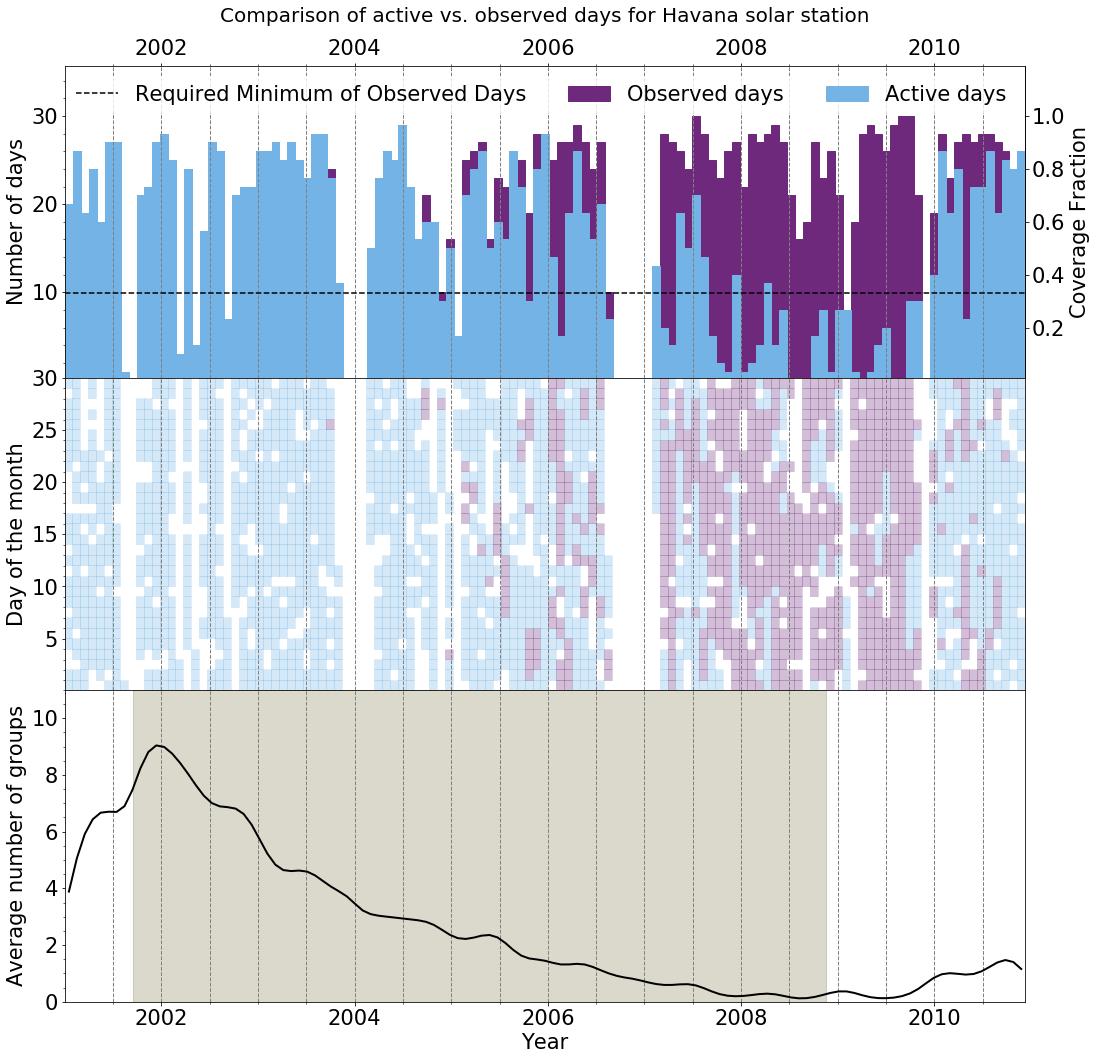

In [15]:
# Observer Plot
# Stack horizontal left ends to level the step-wise plot
pltxOb = np.stack((fyr1Ob,fyr1Ob)).reshape((1,-1),order='F')

# Append max fracyear to clapm aria
pltxOb = np.append(pltxOb,np.max(fyr2Ob))
pltxOb = np.append(pltxOb,np.max(fyr2Ob))

# Stack duplicate array to level the step-wise plot 
pltyOb = np.stack((obsOb,obsOb)).reshape((1,-1),order='F')
pltyGr = np.stack((grpOb,grpOb)).reshape((1,-1),order='F')
pltyAvOb = np.stack((AvGrpOb,AvGrpOb)).reshape((1,-1),order='F')
pltySd = np.stack((SdGrpOb,SdGrpOb)).reshape((1,-1),order='F')
pltyAvSNd = np.stack((AvSNdOb,AvSNdOb)).reshape((1,-1),order='F')
pltySdSNd = np.stack((SdSNdOb,SdSNdOb)).reshape((1,-1),order='F')

# Append zeros to clamp area
pltyOb = np.insert(pltyOb,0,0)
pltyOb = np.append(pltyOb,0)

pltyGr = np.insert(pltyGr,0,0)
pltyGr = np.append(pltyGr,0)

pltyAvOb = np.insert(pltyAvOb,0,0)
pltyAvOb = np.append(pltyAvOb,0)

pltySd = np.insert(pltySd,0,0)
pltySd = np.append(pltySd,0)

pltyAvSNd = np.insert(pltyAvSNd,0,0)
pltyAvSNd = np.append(pltyAvSNd,0)

pltySdSNd = np.insert(pltySdSNd,0,0)
pltySdSNd = np.append(pltySdSNd,0)


plt.rc('font', **font)

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300   # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 3      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

# Dummy axis for right scale
axd = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv])
axd.set_ylim(bottom = 0.01, top = 1.19)
axd.set_ylabel('Coverage Fraction')
axd.yaxis.set_label_position("right")
axd.yaxis.tick_right()


# Days with observations and active days
ax1 = fig.add_axes([ppadh, ppadv + 2*pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
# Add number of days with observations
ax1.fill(pltxOb, pltyOb, color = Clr[2])
ax1.fill(pltxOb, pltyGr, color = Clr[4])
# Add number of days with groups (not including zeros and days without observations)

ax1.plot(np.array([np.min(pltxOb),np.max(pltxOb)]), np.array([1,1])*minObD*MoLngt, 'k--')



# Axes properties
ax1.text(0.5, 1.14,'Comparison of active vs. observed days for ' + NamObs.capitalize(), horizontalalignment='center',
         fontsize=20,
         transform = ax1.transAxes)
ax1.set_ylabel('Number of days')
ax1.legend(['Required Minimum of Observed Days','Observed days','Active days'], loc = 'upper right', ncol = 3, frameon = True, edgecolor = 'none')
ax1.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax1.set_ylim(bottom = 0.01*MoLngt, top = 1.19*MoLngt)
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.xaxis.tick_top()
ax1.minorticks_on()

# Active/observation/missing mesh
AcObMesh = np.isfinite(grpsOb).astype(int)+np.greater(grpsOb,0).astype(int)
xMesh = np.insert(fyr2Ob,0,fyr1Ob[0])
yMesh = np.arange(0,MoLngt+1)

#Colormap
colors = [(1, 1, 1), Clr[2], Clr[4]]
cmap = clrs.LinearSegmentedColormap.from_list('cmap', colors, N=3)

ax2 = fig.add_axes([ppadh, ppadv + pxy/fszv, pxx/fszh, pxy/fszv], sharex=axd)
ax2.pcolormesh(xMesh, yMesh, np.transpose(AcObMesh), cmap = cmap, alpha = 0.3, linewidth = 2)
ax2.set_ylim(bottom = 0.1, top = MoLngt)

# Axes properties
ax2.set_ylabel('Day of the month')
ax2.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax2.minorticks_on()

# Average group number
ax3 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])

for Idx in range(0,cenPoints.shape[0]):
    if vldIntr[Idx]:
        ax3.fill([endPoints[Idx, 0], endPoints[Idx, 0], endPoints[Idx+1, 0], endPoints[Idx+1, 0]], [0, np.ceil(np.nanmax(AvGrpOb))+1, np.ceil(np.nanmax(AvGrpOb))+1, 0 ], color = Clr[1+np.mod(Idx,2)*2], alpha = 0.2)

ax3.plot((fyr1Ob+fyr2Ob)/2, AvGrpOb, color = Clr[0], linewidth = 2)



# Axes properties
ax3.set_xlabel('Year')
ax3.set_ylabel('Average number of groups')
ax3.set_xlim(left = np.min(fyr1Ob), right = np.max(fyr2Ob))
ax3.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax3.minorticks_on()
ax3.set_ylim(bottom = 0, top = np.ceil(np.nanmax(AvGrpOb))+1);

FIGURE: Top: Number of active (non-zero; blue) and observed (purple) days during each month.

Middle: Grid showing each day during the observed period as no-data (white), no groups (purple), and active (blue). The vertical axis denotes the day of the month and the horizontal axis the edges of each month.

Bottom: Average number of groups each month. Shaded areas indicate the separation of observations in sub-domains roughly going from maximum to maximum. White intervals are not used in calibration due to the interval being too small or not having good coverage


## Calculating the solar minimum masks that will be used in the optimization scan for best match
Given that our objective is to calculate the relative of different cycles we can take advantage of our knowledge of cycle progression to narrow the search for an optimum. To do this we create a mask of valid search periods determined by using a window centered on the minima contained within the reference data.

In [16]:
# Temporal Stride in days
dt = 30

# Cycle phase tolerance in years
phTol = 2

# Number of thresholds including 0
thN = 50

# Threshold increments 
thI = 1

# Creating window masks
risMask = np.zeros(REF_Grp.shape[0], dtype=bool) 
decMask = np.zeros(REF_Grp.shape[0], dtype=bool) 

# Applying mask
for cen in cenPointsR: 
    if cen[1]==1: 
        risMask[np.logical_and(REF_Grp['FRACYEAR'].values>=cen[0]-phTol,REF_Grp['FRACYEAR'].values<=cen[0]+phTol)] = True
    else:
        decMask[np.logical_and(REF_Grp['FRACYEAR'].values>=cen[0]-phTol,REF_Grp['FRACYEAR'].values<=cen[0]+phTol)] = True

# Creating cadence mask
cadMask = np.zeros(REF_Grp.shape[0], dtype=bool)
cadMask[range(0,cadMask.shape[0],dt)] = True 

#Storing maks for plotting
risMaskP = risMask.copy()
decMaskP = decMask.copy()

# Creating rising mask
risMask = np.logical_and(cadMask,risMask) 

# Creating decaying mask
decMask = np.logical_and(cadMask,decMask) 

# Turnings Mask into indices
risMaskI = np.array(risMask.nonzero()[0])
decMaskI = np.array(decMask.nonzero()[0])

# Plotting maxima, minima, and search windows

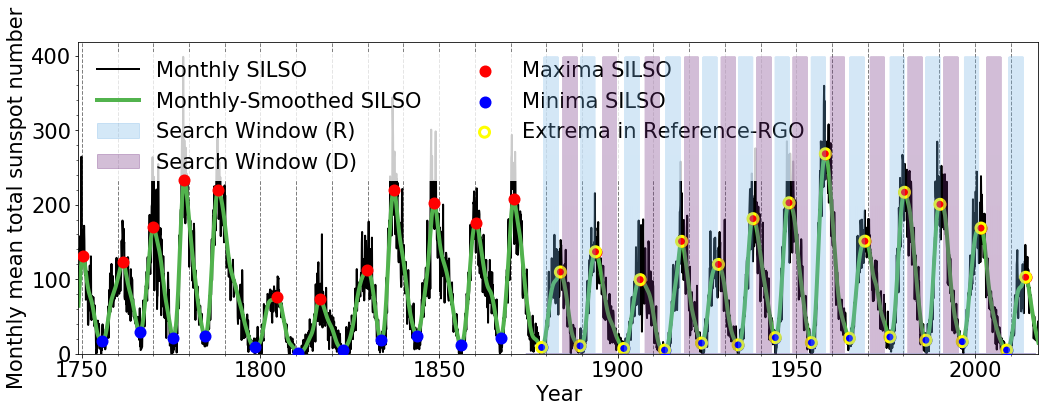

In [17]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1300   # Vertical size of each panel

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Average group number 
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MMEAN'], color = Clr[0], linewidth = 2) 
ax1.plot(SILSO_Sn['FRACYEAR'], SILSO_Sn['MSMOOTH'], color = Clr[3], linewidth = 4) 
ax1.scatter(SIL_maxT, SIL_max, color='r', edgecolor='r', alpha = 1, s=100, linewidths = 2, zorder=10) 
ax1.scatter(SIL_minT, SIL_min, color='b', edgecolor='b', alpha = 1, s=100, linewidths = 2, zorder=10) 
ax1.scatter(REF_minT, REF_min, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10) 
ax1.scatter(REF_maxT, REF_max, color='none', edgecolor='yellow', alpha = 1, s=100, linewidths = 3, zorder=10) 
ax1.fill(REF_Grp['FRACYEAR'],  risMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[4], color = Clr[4], alpha = 0.3, zorder=15) 
ax1.fill(REF_Grp['FRACYEAR'],  decMask*np.max(SILSO_Sn['MMEAN']), edgecolor = Clr[2], color = Clr[2], alpha = 0.3, zorder=15) 


ax1.legend(['Monthly SILSO','Monthly-Smoothed SILSO','Search Window (R)','Search Window (D)','Maxima SILSO', 'Minima SILSO','Extrema in Reference-RGO'], loc = 'upper left', ncol = 2, frameon = True, edgecolor = 'none')

# Axes properties
ax1.set_xlabel('Year')
ax1.set_ylabel('Monthly mean total sunspot number')
ax1.set_xlim(left = np.min(SILSO_Sn['FRACYEAR']), right = np.max(SILSO_Sn['FRACYEAR']))
ax1.grid(color=(0.5,0.5,0.5), linestyle='--', linewidth=1, axis='x', which='both')
ax1.minorticks_on()
ax1.set_ylim(bottom = 0);


FIGURE: Maxima and minima determinid using SILSO's v2 series. This help us reduce significantly the number of steps on the optimization scan. This way, rising (decaying) phases of the observer only need to be compared with rising (decaying) phasis of the reference

# Calculating the optimal threshold for low, medium, and high solar activity

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in less
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in less


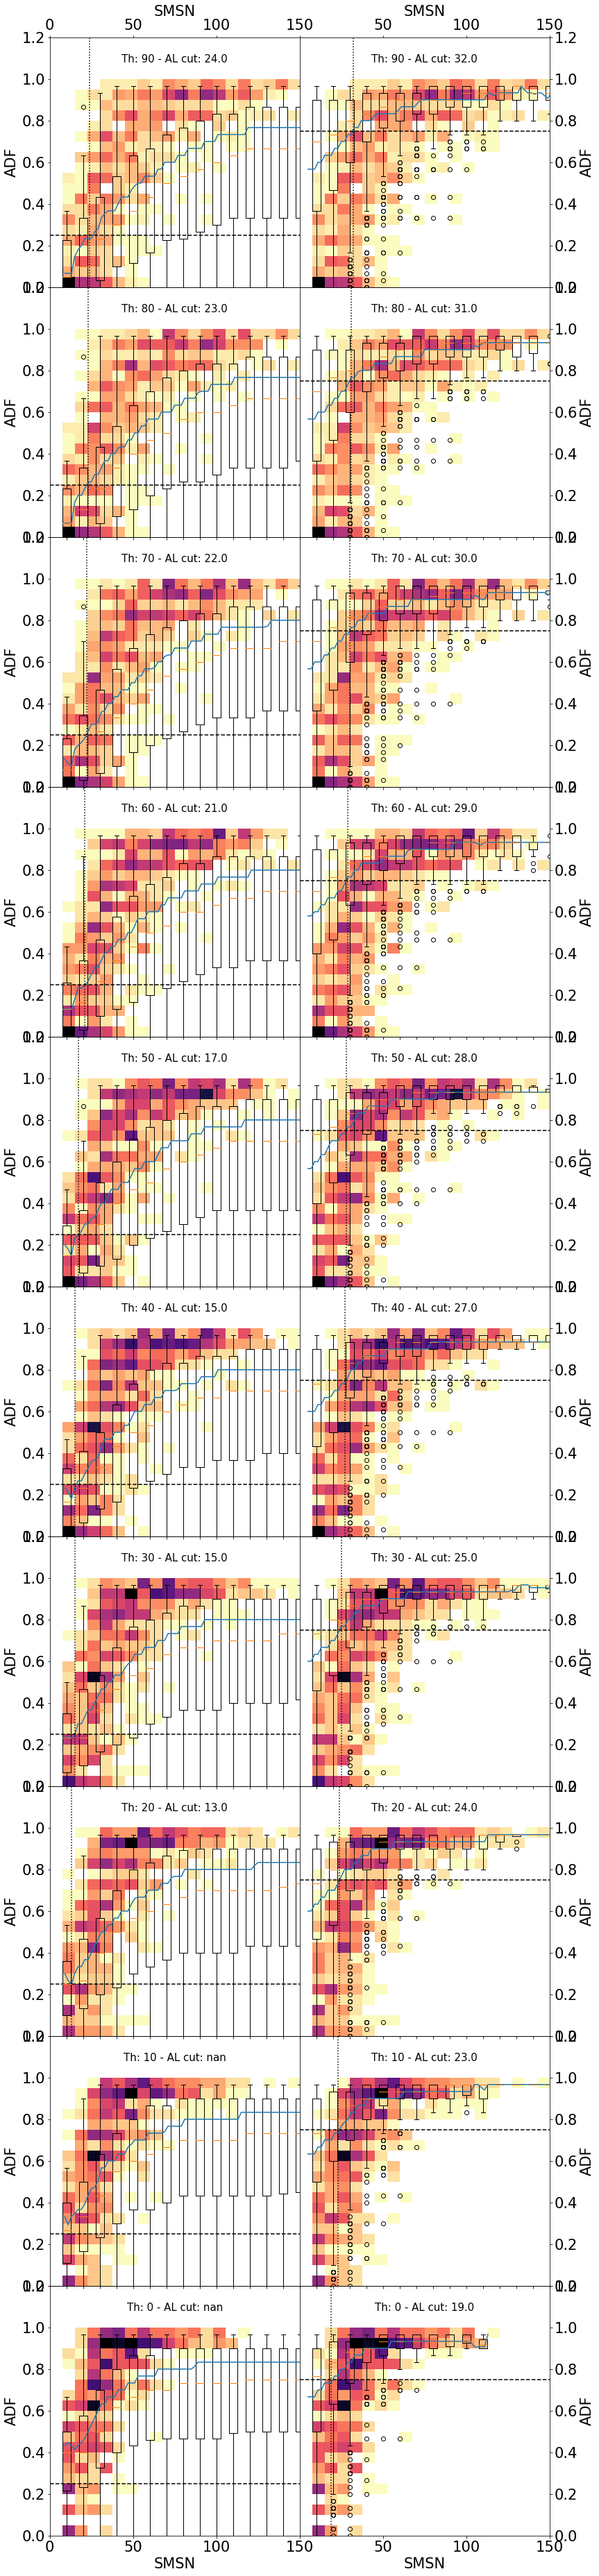

In [33]:
thN = 10  # Number of thresholds to plot
thS = 10  # Threshold increment
pctl = 60 # Percentile of 

# creating matrix to define thresholds
TREFDat = REF_Grp['GROUPS'].values.copy()
TREFSNd = REF_Grp['AVGSNd'].values.copy()

GDREF = np.zeros((thN,np.int(TREFDat.shape[0]/MoLngt)))
ODREF = np.zeros((thN,np.int(TREFDat.shape[0]/MoLngt)))
SNdREF = np.zeros((thN,np.int(TREFDat.shape[0]/MoLngt)))

for TIdx in range(0,thN):
            grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thS) ,axis = 1).astype(float)
            grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan
            
            TgrpsREF = grpsREFw[0:np.int(grpsREFw.shape[0]/MoLngt)*MoLngt].copy()
            TgrpsREF = TgrpsREF.reshape((-1,MoLngt))            
            TSNdREF = TREFSNd[0:np.int(TREFSNd.shape[0]/MoLngt)*MoLngt].copy()
            TSNdREF = TSNdREF.reshape((-1,MoLngt))            
            # Number of days with groups
            GDREF[TIdx,:] = np.sum(np.greater(TgrpsREF,0),axis=1)
            # Number of days with observations
            ODREF[TIdx,:]= np.sum(np.isfinite(TgrpsREF),axis=1)            
            # Number of quiet days
            QDREF = ODREF-GDREF
            # ACTIVE DAY FRACTION
            ADFREF = GDREF/ODREF
            # Monthly sunspot number
            SNdREF[TIdx,:]=np.mean(TSNdREF,axis=1) 


# Plotting threshold           
plt.rc('font', **font)
    
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 1      # Fraction of the panel devoted to histograms

nph = 2      # Number of horizontal panels
npv = thN    # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units

Nbinsx = 20
Nbinsy = 20

edgesx = np.arange(0,Nbinsy+1)/Nbinsy*150
edgesy = np.arange(0,Nbinsy+1)/Nbinsy

bprange = np.arange(10,175,10)
pprange = np.arange(5,175,2)


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))

LowALlim = np.zeros(thN)
HighALlim = np.zeros(thN)

for n in range(0,thN):
    
            pltmsk = np.logical_and(ODREF[n,:]==MoLngt,ADFREF[n,:]<1)
        
            #ax1
            ax1 = fig.add_axes([ppadh, ppadv+n*pxy/fszv, pxx/fszh, pxy/fszv], label= 'b1')
            ax1.hist2d(SNdREF[n,:][pltmsk], ADFREF[n,:][pltmsk], bins=[edgesx,edgesy], cmap=plt.cm.magma_r,cmin=1) 
            
            bpdat = []    
            for AL in bprange:
                bpdat.append(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]<=AL)])
                    
            ax1.boxplot(bpdat, positions=bprange, widths=5)
            
            ALP = pprange*np.nan
            for ALi in np.arange(0,pprange.shape[0]):
                if (np.sum(np.logical_and(pltmsk, SNdREF[n,:]<=pprange[ALi]))>0):ALP[ALi] = np.percentile(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]<=pprange[ALi])], pctl)
                        
            ax1.plot(pprange, ALP)
            ax1.plot([0,150],[0.25,0.25],color='k',linestyle='--')
            
            intrsc = np.where(np.abs(ALP-0.25)==np.nanmin(np.abs(ALP-0.25)))[0]
            cut = np.mean(pprange[intrsc])        
            if np.sum(ALP<0.25)==0:
                cut = np.nan
            
            LowALlim[n] = cut          
                
            ax1.plot([cut,cut],[0,1.2],color='k',linestyle=':')

            # Axes properties
            ax1.text(0.5, 0.9,'Th: ' + str(n*thS) + ' - AL cut: ' + str(cut), horizontalalignment='center',fontsize=15,transform = ax1.transAxes)
            ax1.set_ylabel('ADF')
            ax1.set_ylim(top=1.2,bottom=0)
            ax1.set_xlim(left = 0, right=150)    

            
            #ax2
            ax2 = fig.add_axes([ppadh+pxx/fszh, ppadv+n*pxy/fszv, pxx/fszh, pxy/fszv], label= 'b2')
            ax2.hist2d(SNdREF[n,:][pltmsk], ADFREF[n,:][pltmsk], bins=[edgesx,edgesy], cmap=plt.cm.magma_r,cmin=1)
    
            bpdat = []
            for AL in bprange:        
                bpdat.append(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]>=AL)])
                                
            ax2.boxplot(bpdat, positions=bprange, widths=5)
    
            ALP = pprange*np.nan
            for ALi in np.arange(0,pprange.shape[0]):
                if (np.sum(np.logical_and(pltmsk, SNdREF[n,:]>=pprange[ALi]))>0):ALP[ALi] = np.percentile(ADFREF[n,:][np.logical_and(pltmsk, SNdREF[n,:]>=pprange[ALi])], 100-pctl)
            
            ax2.plot(pprange, ALP)
            ax2.plot([0,150],[0.75,0.75],color='k',linestyle='--')

            intrsc = np.where(np.abs(ALP-0.75)==np.nanmin(np.abs(ALP-0.75)))[0]
            cut = np.mean(pprange[intrsc])
            if np.sum(ALP<0.75)==0:
                cut = np.nan
            
            HighALlim[n] = cut            
            
            ax2.plot([cut,cut],[0,1.2],color='k',linestyle=':')            

            # Axes properties
            ax2.set_ylabel('ADF')
            ax2.yaxis.set_label_position("right")
            ax2.text(0.5, 0.9,'Th: ' + str(n*thS) + ' - AL cut: ' + str(cut), horizontalalignment='center',fontsize=15,transform = ax2.transAxes)
            ax2.set_ylim(top=1.2,bottom=0)

            ax2.yaxis.tick_right()
            ax2.set_xlim(left = 0, right=150)

            if n>0&n<thN-1:
                ax1.set_xticklabels([])
                ax2.set_xticklabels([])        
            else:
                ax1.set_xlabel('SMSN')
                ax2.set_xlabel('SMSN')
                ax1.set_xticks([0,50,100,150])
                ax1.set_xticklabels([0,50,100,150])
                ax2.set_xticks([50,100,150])
                ax2.set_xticklabels([50,100,150])

            if n==thN-1:
                ax1.xaxis.set_label_position("top")
                ax1.xaxis.tick_top()
                ax2.xaxis.tick_top()
                ax2.xaxis.set_label_position("top")
                ax1.set_xlabel('SMSN')
                ax2.set_xlabel('SMSN')
                ax1.set_xticks([0,50,100,150])
                ax1.set_xticklabels([0,50,100,150])
                ax2.set_xticks([50,100,150])
                ax2.set_xticklabels([50,100,150])


            
# fit for low solar activity
xlow = np.arange(0,thN)*thS
xlow = xlow[np.isfinite(LowALlim)]
ylow = LowALlim[np.isfinite(LowALlim)]
fitlow = np.polyfit(xlow,ylow,deg=1)
a1low = fitlow[0]
a0low = fitlow[1]

# fit for high solar activity
xhigh = np.arange(0,thN)*thS
xhigh = xhigh[np.isfinite(HighALlim)]
yhigh = HighALlim[np.isfinite(HighALlim)]
fithigh = np.polyfit(xhigh,yhigh,deg=1)
a1high = fithigh[0]
a0high = fithigh[1]


# Calculating number of active and observed days¶
For each of the observer subintervals specified in "Breaking Observer Period into rising (decaying) Intervals" we do a window scan during the rising (decays) contained in the reference. For each step in the window scan we:

Select an interval in the reference of equal duration as in the observer's sub-interval. Imprint missing days on both reference and observer Calculate number of active days and number of days with observations

In [20]:
# Creating Storing dictionaries
# Number of days with groups
GDObsI = []
GDREFI = []  

# Number of days with observations
ODObsI = []    
ODREFI = [] 

# Number of days without observations
QDObsI = []
QDREFI = []

# Monthly (from daily) sunspot number
SNdObsI = []

#creating storing dictionaries for ADF
ADFObsI = []
ADFREFI = []


# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):    
    
    print('Center:', np.round(cenPoints[siInx, 0],2), 'Edges:', np.round(endPoints[siInx, 0],2), np.round(endPoints[siInx+1, 0],2))
    
    # Perform analysis Only if the period is valid
    if vldIntr[siInx]: 
    
        print('Valid Interval')
        
        # Defining mask based on the interval type (rise or decay)
        if cenPoints[siInx, 1] > 0: 
            cadMaskI = risMaskI
        else:
            cadMaskI = decMaskI

        # Selecting interval
        TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'GROUPS'].values.copy()
        TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'FRACYEAR'].values.copy()
        
        TObsSNd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                             ,'AVGSNd'].values.copy()

        # Find index of center of sub-interval
        minYear = np.min(np.absolute(TObsFYr-cenPoints[siInx, 0]))
        obsMinInx = (np.absolute(TObsFYr-cenPoints[siInx, 0])==minYear).nonzero()[0][0] #this is the center of the interval for given observer

        # Creating Storing Variables
        # Number of days with groups
        GDObs = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt)))   
        GDREF = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt))) 

        # Number of days with observations
        ODObs = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt)))   
        ODREF = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt)))     
        
        # mask for monthly ADF
        ADFObs = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt))) 
        ADFREF = np.zeros((thN,cadMaskI.shape[0],np.int(TObsDat.shape[0]/MoLngt))) 

        # Going through different thresholds
        for TIdx in range(0,thN):
            
            # Calculating number of groups in reference data for given threshold
            grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thI) ,axis = 1).astype(float)
            grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan
            
            # Final fit to define solar activity thresholds
            highth = a1high*TIdx*thI + a0high
            if TIdx*thI >= np.min(xlow): 
                lowth = a1low*TIdx*thI + a0low
            else:
                lowth = 0

            # Going through different shifts
            for SIdx in range(0,cadMaskI.shape[0]): 
                
                # Selecting the maximum integer amount of "months" out of the original data
                TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()

                TObsSNd = TObsSNd[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy() 
                
                #Calculating bracketing indices
                Idx1 = cadMaskI[SIdx]-obsMinInx
                Idx2 = Idx1 + TgrpsOb.shape[0] 

                #Selecting reference window of matching size to observer sub-interval;
                TgrpsREF = grpsREFw[Idx1:Idx2].copy()
                TSNdREF = REF_Grp['AVGSNd'][Idx1:Idx2].values.copy()

                # Making sure selections have the same length
                if TgrpsREF.shape[0] == TgrpsOb.shape[0]:

                    # Reshaping into "months"
                    TgrpsOb = TgrpsOb.reshape((-1,MoLngt))           
                    TgrpsREF = TgrpsREF.reshape((-1,MoLngt)) 
                    
                    TObsSNd = TObsSNd.reshape((-1,MoLngt))           
                    TSNdREF = TSNdREF.reshape((-1,MoLngt))

                    # Imprinting missing days
                    # OBSERVER
                    TgrpsOb[np.isnan(TgrpsREF)] = np.nan
                    # REFERENCE
                    TgrpsREF[np.isnan(TgrpsOb)] = np.nan                   

                    # Number of days with groups
                    # OBSERVER
                    GDObs[TIdx,SIdx,:] = np.sum(np.greater(TgrpsOb,0),axis=1)
                    # REFERENCE
                    GDREF[TIdx,SIdx,:] = np.sum(np.greater(TgrpsREF,0),axis=1)

                    # Number of days with observations
                    # OBSERVER
                    ODObs[TIdx,SIdx,:] = np.sum(np.isfinite(TgrpsOb),axis=1)
                    # REFERENCE
                    ODREF[TIdx,SIdx,:] = np.sum(np.isfinite(TgrpsREF),axis=1)
                    
                    # Number of quiet days
                    # OBSERVER
                    QDObs = ODObs-GDObs
                    # REFERENCE
                    QDREF = ODREF-GDREF
                    
                    # Monthly sunspot number
                    SNdObs = np.mean(TObsSNd,axis=1) 
                    SNdREF = np.mean(TSNdREF,axis=1)

                    # Solar activity level mask
                    LMObs=SNdObs<=lowth
                    LMRef=SNdREF<=lowth

                    MMObs=np.logical_and((lowth<SNdObs), (SNdObs<highth))
                    MMRef=np.logical_and((lowth<SNdREF), (SNdREF<highth))

                    HMObs=(SNdObs>=highth)
                    HMRef=(SNdREF>=highth)
                    
                    # ADF
                    ADFObs[TIdx,SIdx,LMObs]=GDObs[TIdx,SIdx][LMObs]/MoLngt
                    ADFREF[TIdx,SIdx,LMRef]=GDREF[TIdx,SIdx][LMRef]/MoLngt

                    ADFObs[TIdx,SIdx,MMObs]=GDObs[TIdx,SIdx][MMObs]/ODObs[TIdx,SIdx][MMObs]
                    ADFREF[TIdx,SIdx,MMRef]=GDObs[TIdx,SIdx][MMRef]/ODREF[TIdx,SIdx][MMRef]

                    ADFObs[TIdx,SIdx,HMObs]=(MoLngt-QDObs[TIdx,SIdx][HMObs])/MoLngt
                    ADFREF[TIdx,SIdx,HMRef]=(MoLngt-QDREF[TIdx,SIdx][HMRef])/MoLngt                                       
                        
    # If period is not valid append empty variavbles
    else:        
        print('INVALID Interval')        
        GDObs = []
        GDREF = []
        ODObs = []
        ODREF = []
        
        QDObs = []
        QDREF = []
        SNdObs = []
        
        ADFObs = []
        ADFREF = []
        
    print(' ')
  
    
    # Appending calculated days to list of sub-intervals
    GDObsI.append(GDObs) 
    GDREFI.append(GDREF)
    ODObsI.append(ODObs)
    ODREFI.append(ODREF)
    
    QDObsI.append(QDObs)
    QDREFI.append(QDREF)
    SNdObsI.append(SNdObs)
    
    ADFObsI.append(ADFObs)
    ADFREFI.append(ADFREF)


print(GDObs)
print(QDObs)
print(ODObs)
print(SNdObs)
print(ADFObs)


Center: 2005.29 Edges: 2001.71 2008.87
Valid Interval


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in true_divide


 
[[[13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  ...
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  5.]]

 [[13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  ...
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  5.]]

 [[13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  ...
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  5.]]

 ...

 [[13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  ...
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  5.]]

 [[13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  ...
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.  7.]
  [13. 22. 24. ...  0.  1.

## The Earth Mover's Distance (Wasserstein metric)
As part of our effort to make ADF more robust we introduce the Earth Mover's distance (EMD) to quantify how different are the Observer's and reference's distribution of ADFs.

See description paper here

The basic idea of the EMD is to depict distributions as piles of dirt and quantify the amount of "work" that an earth mover would need to do in order to transform one distribution into the other. Here we use the pyemd package:

https://github.com/wmayner/pyemd

## Calculating the Earth's Mover Distance using a sliding window
The idea is to optimize the fit between the reference and different sections of the observer's ADF distributions simultaneously in time and threshold. The cell below performs this operation. We use prior knowledge of cycle progression to limit the search to periods around cycle minimum (the centerpoints of our sub-intervals).

In [21]:
from pyemd import emd

# Creating Storing dictionaries for distance matrices
EMDD = []
EMDtD = [] 
EMDthD = []

# Calculation of distance matrix to be used in the Earth Movers Metric
x = np.arange(0,MoLngt+1)
y = np.arange(0,MoLngt+1)
xx, yy = np.meshgrid(x, y)
Dis = np.absolute(np.power(xx-yy,1))

# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]): 
    
    print('Center:', np.round(cenPoints[siInx, 0],2), 'Edges:', np.round(endPoints[siInx, 0],2), np.round(endPoints[siInx+1, 0],2))
    
    # Perform analysis Only if the period is valid
    if vldIntr[siInx]: 
    
        print('Valid Interval')
        
        # Defining mask based on the interval type (rise or decay)
        if cenPoints[siInx, 1] > 0:
            cadMaskI = risMaskI
        else:
            cadMaskI = decMaskI          
            
        # Pre-allocating EMD matrix and associated coordinate matrices.  A large default distance valued is used 
        # to account for missing points
        EMD   = np.ones((GDREFI[siInx].shape[0],GDREFI[siInx].shape[1]))*1e16
        EMDt  = np.zeros((GDREFI[siInx].shape[0],GDREFI[siInx].shape[1]))
        EMDth = np.zeros((GDREFI[siInx].shape[0],GDREFI[siInx].shape[1]))
        
        # Going through different thresholds
        for TIdx in range(0,thN): #thN=50 and thI=2

            # Going through different shifts
            for SIdx in range(0,cadMaskI.shape[0]): 
                
                if np.any(ODObsI[siInx][TIdx,SIdx,:]!=0) and np.any(ODREFI[siInx][TIdx,SIdx,:]!=0):
                
                    # Calculating Earth Mover's Distance
                    ADFObsDis, bins = np.histogram(
                        ADFObsI[siInx][TIdx,SIdx,ODObsI[siInx][TIdx,SIdx,:]/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    
                        
                    ADFREFDis, bins = np.histogram(
                        ADFREFI[siInx][TIdx,SIdx,ODREFI[siInx][TIdx,SIdx,:]/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)                             
                                  
                   
                    EMD[TIdx,SIdx] = emd(ADFREFDis.astype(np.float64),ADFObsDis.astype(np.float64),Dis.astype(np.float64))

                # Storing coordinates of EMD distances
                EMDt[TIdx,SIdx] = REF_Grp['FRACYEAR'].values[cadMaskI[SIdx]]
                EMDth[TIdx,SIdx]= TIdx*thI
                        
    # If period is not valid append empty variables
    else:        
        print('INVALID Interval')
        EMD = []
        EMDt = []
        EMDth = []
    
    print(' ')
    
    EMDD.append(EMD)
    EMDtD.append(EMDt)
    EMDthD.append(EMDth)
    
print(EMD)
print(EMDt)
print(EMDth)

Center: 2005.29 Edges: 2001.71 2008.87
Valid Interval
 
[[129.8623089  116.30190658 101.91825247 ...  56.71208301  66.98637123
   75.20654301]
 [129.45133068 115.89094068 101.50688425 ...  57.94568301  66.57451069
   75.20570301]
 [129.04114479 115.48000479 101.09591836 ...  59.58942657  66.98630425
   76.43855836]
 ...
 [ 73.15093356  60.41141301  51.78049069 ... 129.8626989  128.62990356
  130.27368246]
 [ 72.32898945  60.00043479  51.78049069 ... 129.8626989  128.62990356
  130.27368246]
 [ 64.10958534  55.48012068  41.50697712 ... 140.13613479 139.72537356
  136.43784247]]
[[1884.72131148 1884.80327869 1884.8852459  ... 2007.10684932
  2007.1890411  2007.27123288]
 [1884.72131148 1884.80327869 1884.8852459  ... 2007.10684932
  2007.1890411  2007.27123288]
 [1884.72131148 1884.80327869 1884.8852459  ... 2007.10684932
  2007.1890411  2007.27123288]
 ...
 [1884.72131148 1884.80327869 1884.8852459  ... 2007.10684932
  2007.1890411  2007.27123288]
 [1884.72131148 1884.80327869 1884.8852

## Plotting the optimization matrix between reference and observer for each sub-interval separately
For comparison, if the observer has a coincident time with the reference, we also calculate the EMD using exact matches.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:187: RuntimeWarning: invalid value encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:188: RuntimeWarning: invalid value encountered in true_divide


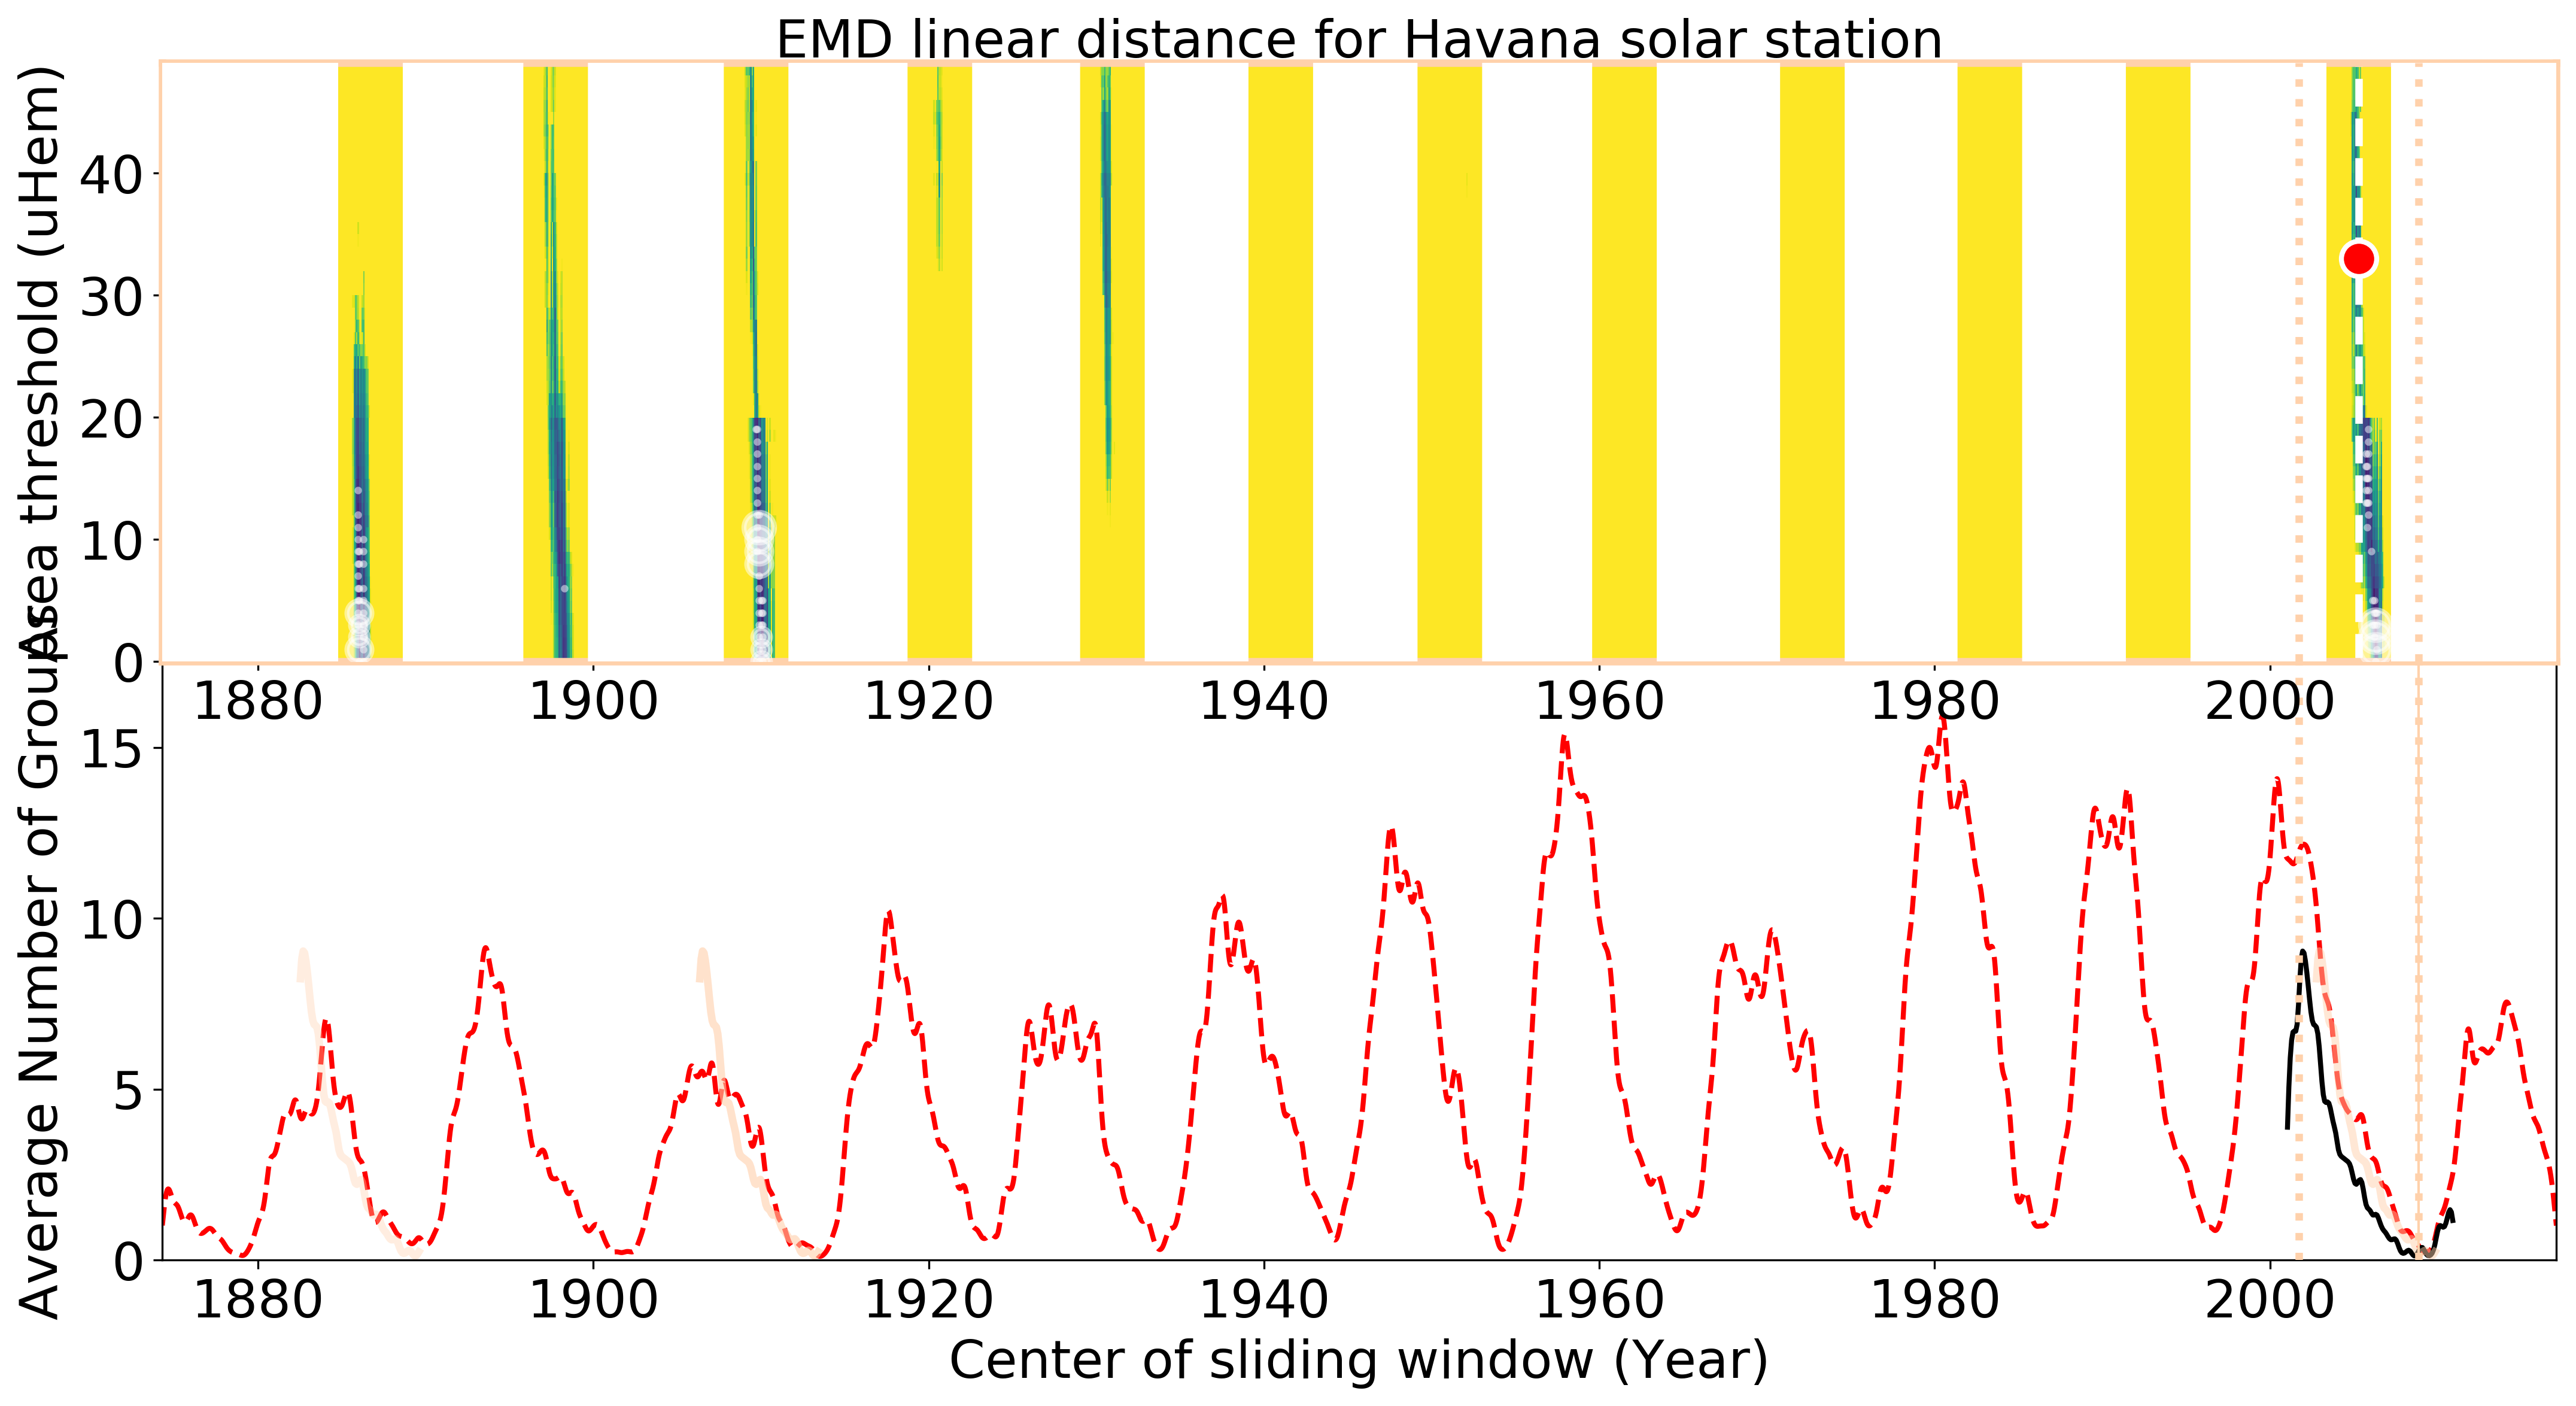

In [22]:
# Number of top best matches to keep
nBest = 50

# Creating Storing dictionaries to store best thresholds
bestTh = []

# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000   # Vertical size of each panel

nph = 1                       # Number of horizontal panels
npv = cenPoints.shape[0]+1    # Number of vertical panels 

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


pltx = (fyr1Ob+fyr2Ob)/2

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1) 

# Plotting Observer
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2) 


# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)

# EMD Pcolor
plt.viridis()

# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    # Creating axis
    ax1 = fig.add_axes([ppadh, ppadv + (siInx+1)*(pxy/fszv+ppadv2), pxx/fszh, pxy/fszv])
    
    # Defining mask based on the interval type (rise or decay)
    if cenPoints[siInx, 1] > 0:
        cadMaskI = risMaskI
        cadMask  = risMaskP
    else:
        cadMaskI = decMaskI
        cadMask  = decMaskP
        
     # Selecting interval
    TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy()
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'FRACYEAR'].values.copy()
    TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'ORDINAL'].values.copy()              
    TObsSNd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'AVGSNd'].values.copy()    
    
    # Plot Matrix Only if the period is valid
    if vldIntr[siInx]:  
            
        # Creating matrix for sorting and find the best combinations of threshold and shift
        OpMat = np.concatenate((EMDtD[siInx].reshape((-1,1)),EMDthD[siInx].reshape((-1,1)),EMDD[siInx].reshape((-1,1))), axis = 1)
        
        # Sort according to EMD to find the best matches
        I = np.argsort(OpMat[:,2],axis = 0)
        OpMat = np.squeeze(OpMat[I,:])

        # Find index of minimum inside sub-interval
        minYear = np.min(np.absolute(TObsFYr-cenPoints[siInx, 0]))
        obsMinInx = (np.absolute(TObsFYr-cenPoints[siInx, 0])==minYear).nonzero()[0][0] 

        #Initialize varialbes to identify the optimum threshold for the period of overlap
        tmpEMD = 1e16
        tmpt   = np.nan
        tmpth  = np.nan 

        # Calculate optimum threshold for real period of overlap if it exists    
        # Check if real if interval is present in Observations
        if (TObsFYr[obsMinInx] > np.min(REF_Dat['FRACYEAR'])) and (TObsFYr[obsMinInx] < np.max(REF_Dat['FRACYEAR'])): 

            # Check if first element is present in reference
            if np.any(REF_Dat['ORDINAL']==TObsOrd[0]):

                # Selecting the maximum integer amount of "months" out of the original data
                TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()
                
                TObsSNd = TObsSNd[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy() 

                # Calculating bracketing indices
                Idx1 =  (REF_Dat['ORDINAL']==TObsOrd[0]).nonzero()[0][0]
                Idx2 = Idx1 + TgrpsOb.shape[0]
                
                TSNdREF = REF_Grp['AVGSNd'][Idx1:Idx2].values.copy()
                TSNdREF = TSNdREF.reshape((-1,MoLngt))
                
                # Going through different thresholds
                for TIdx in range(0,thN):

                    # Calculating number of groups in reference data for given threshold
                    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],TIdx*thI) ,axis = 1).astype(float)
                    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan                       
            
                    # Final fit to define solar activity thresholds
                    highth = a1high*TIdx*thI + a0high
                    if TIdx*thI >= np.min(xlow): 
                        lowth = a1low*TIdx*thI + a0low
                    else:
                        lowth = 0

                    # Selecting the maximum integer amount of "months" out of the original data
                    TgrpsOb = TObsDat[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()
                    
                    TObsSNd = TObsSNd[0:np.int(TObsDat.shape[0]/MoLngt)*MoLngt].copy()

                    #Selecting reference window of matching size to observer sub-interval
                    TgrpsREF = grpsREFw[Idx1:Idx2].copy()                

                    # Reshaping into "months"
                    TgrpsOb = TgrpsOb.reshape((-1,MoLngt))            
                    TgrpsREF = TgrpsREF.reshape((-1,MoLngt))
                    
                    TObsSNd = TObsSNd.reshape((-1,MoLngt))   

                    # Imprinting missing days
                    # OBSERVER
                    TgrpsOb[np.isnan(TgrpsREF)] = np.nan
                    # REFERENCE
                    TgrpsREF[np.isnan(TgrpsOb)] = np.nan

                    # Number of days with groups
                    # OBSERVER
                    GDObsT = np.sum(np.greater(TgrpsOb,0),axis=1)
                    # REFERENCE
                    GDREFT = np.sum(np.greater(TgrpsREF,0),axis=1)

                    # Number of days with observations
                    # OBSERVER
                    ODObsT = np.sum(np.isfinite(TgrpsOb),axis=1)
                    # REFERENCE
                    ODREFT = np.sum(np.isfinite(TgrpsREF),axis=1)
                    
                    # Number of quiet days
                    # OBSERVER
                    QDObsT = ODObsT-GDObsT
                    # REFERENCE
                    QDREFT = ODREFT-GDREFT
                    
                    # Monthly sunspot number
                    SNdObsT = np.mean(TObsSNd,axis=1)                   
                    SNdREFT = np.mean(TSNdREF,axis=1)
                    
                    # Solar activity level mask
                    LMObs=SNdObsT<=lowth
                    LMRef=SNdREFT<=lowth

                    MMObs=np.logical_and((lowth<SNdObsT), (SNdObsT<highth))
                    MMRef=np.logical_and((lowth<SNdREFT), (SNdREFT<highth))

                    HMObs=(SNdObsT>=highth)
                    HMRef=(SNdREFT>=highth)
                    
                    
                    # ADF
                    ADFObs=GDObsT/MoLngt
                    ADFREF=GDREFT/MoLngt

                    ADFObs[MMObs]=GDObsT[MMObs]/ODObsT[MMObs]
                    ADFREF[MMRef]=GDObsT[MMRef]/ODREFT[MMRef]

                    ADFObs[HMObs]=(MoLngt-QDObsT[HMObs])/MoLngt
                    ADFREF[HMRef]=(MoLngt-QDREFT[HMRef])/MoLngt
                    
                    
                    # Calculating Earth Mover's Distance
                    ADFObsDis, bins = np.histogram(
                        ADFObs[ODObsT/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
                    
                        
                    ADFREFDis, bins = np.histogram(
                        ADFREF[ODREFT/MoLngt>=minObD],
                        bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)   
                                       
                
                    tmp = emd(ADFREFDis.astype(np.float64),ADFObsDis.astype(np.float64),Dis.astype(np.float64))

#                     #Calculating Chi-Square distance
#                     ADFObs, bins = np.histogram(GDObsT[ODObsT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)
#                     ADFREF, bins = np.histogram(GDREFT[ODREFT/MoLngt>=minObD]/MoLngt, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt)

#                     # Calculating numerator and denominator for Chi-square distance
#                     Nom = np.power(ADFObs-ADFREF,2)
#                     #Den = np.power(ADFObs,2) + np.power(ADFREF,2)
#                     Den = ADFObs + ADFREF

#                     # Removing zeros in denominator
#                     Nom = Nom[Den!=0]
#                     Den = Den[Den!=0]

#                     # Calculating Chi-square distance
#                     tmp = np.sum(np.divide(Nom,Den))

                    # Udating variables
                    if tmp<tmpEMD:
                        tmpEMD = tmp
                        tmpt   = TObsFYr[obsMinInx]
                        tmpth  = TIdx*thI


        OpMat = np.insert(OpMat,0,[tmpt,tmpth,tmpEMD],axis=0)            
            
        # Calculating mesh for plotting
        x = REF_Grp['FRACYEAR'].values[cadMaskI]
        y = np.arange(0,thN)*thI
        xx, yy = np.meshgrid(x, y)             

        #Plotting Optimization Matrix
        mesh = ax1.pcolormesh(xx,yy,EMDD[siInx], alpha = 1, linewidth = 2, vmin = np.min(EMDD[siInx]), vmax = 6*np.min(EMDD[siInx]))
            
        # True Interval
        ax1.scatter(OpMat[0,0], OpMat[0,1], c = 'r', edgecolors = 'w',linewidths = 2, s = 200, zorder=11)

        # Best 5 points
        for i in range(1,5):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 150, zorder=11, alpha = 0.5)
            ax2.plot(pltx[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))]-cenPoints[siInx, 0]+OpMat[i,0]
                     , AvGrpOb[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))], color = Clr[5-siInx], linewidth = 3
                     , alpha = 0.2)

        # Best 5-10 points
        for i in range(5,10):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 100, zorder=11, alpha = 0.5)
            ax2.plot(pltx[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))]-cenPoints[siInx, 0]+OpMat[i,0]
                     , AvGrpOb[np.logical_and(pltx>=np.min(TObsFYr),pltx<np.max(TObsFYr))], color = Clr[5-siInx], linewidth = 3
                     , alpha = 0.2)

        # Best 10-15 points
        for i in range(10,15):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 50, zorder=11, alpha = 0.5)

        # Best 15-20 points
        for i in range(15,100):
            ax1.scatter(OpMat[i,0], OpMat[i,1], c = 'w',linewidths = 2, s = 1, zorder=11, alpha = 0.5)
            
        # Masking Gaps
        pltMsk  = np.logical_not(cadMask)
        ax1.fill_between(REF_Grp['FRACYEAR'],  REF_Grp['FRACYEAR']*0, y2=REF_Grp['FRACYEAR']*0+thN, where=pltMsk, color = 'w', zorder=10)

        # Adding best points
        bestTh.append(OpMat[1:nBest,:])
    
    # If period not valid store an empty array
    else:
        bestTh.append([])

    # Plotting real location
    ax1.plot(np.array([1,1])*TObsFYr[obsMinInx], np.array([0,np.max(y)]),'w--', linewidth = 3)
    
    # Plotting edges
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])            
            
    # Axes properties
    ax1.set_ylabel('Area threshold (uHem)')
    ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
    ax1.set_ylim(bottom = 0, top = np.max(y))
    
    ax1.spines['bottom'].set_color(Clr[5-siInx])
    ax1.spines['bottom'].set_linewidth(3) 
    ax1.spines['top'].set_color(Clr[5-siInx]) 
    ax1.spines['top'].set_linewidth(3) 
    ax1.spines['right'].set_color(Clr[5-siInx])
    ax1.spines['right'].set_linewidth(3) 
    ax1.spines['left'].set_color(Clr[5-siInx])
    ax1.spines['left'].set_linewidth(3)     
    
    # Adding title
    if siInx==cenPoints.shape[0]-1:
        #ax1.text(0.5, 1.01,'Chi-Square (y-y_exp)^2/(y^2+y_exp^2) for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.5, 1.01,'EMD linear distance for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)

fig.savefig(NamObs.capitalize() + '_EMD_1.png', bbox_inches='tight', dpi = 103, pad_inches=0)

FIGURE: Bottom: Reference average number of groups (red). True location of the observer groups (black). Observer sub-intervals (vertical dotted lines). Top-ten shifts with the best match between observer and reference ADFs (faint colored curves). Each sub-interval is color coded.

Top panels: Each panel shows the distance measured between observer and reference ADFs as a function of threshold and shift for a given sub-interval. The true location of the sub-interval is shown using colored vertical dotted lines. The true shift is indicated by a vertical white dashed line. The optimal threshold for the true interval is shown with a red dot. The best 20 points are denoted by white circles (the smaller the distance, the larger the dot). In the colormap, dark blue denotes a good match and bright yellow a bad match. The color-scale is saturated at 6 times the minimum ADF distance. Invalid intervals are blank.

## Plotting distribution of Thresholds for each interval¶

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


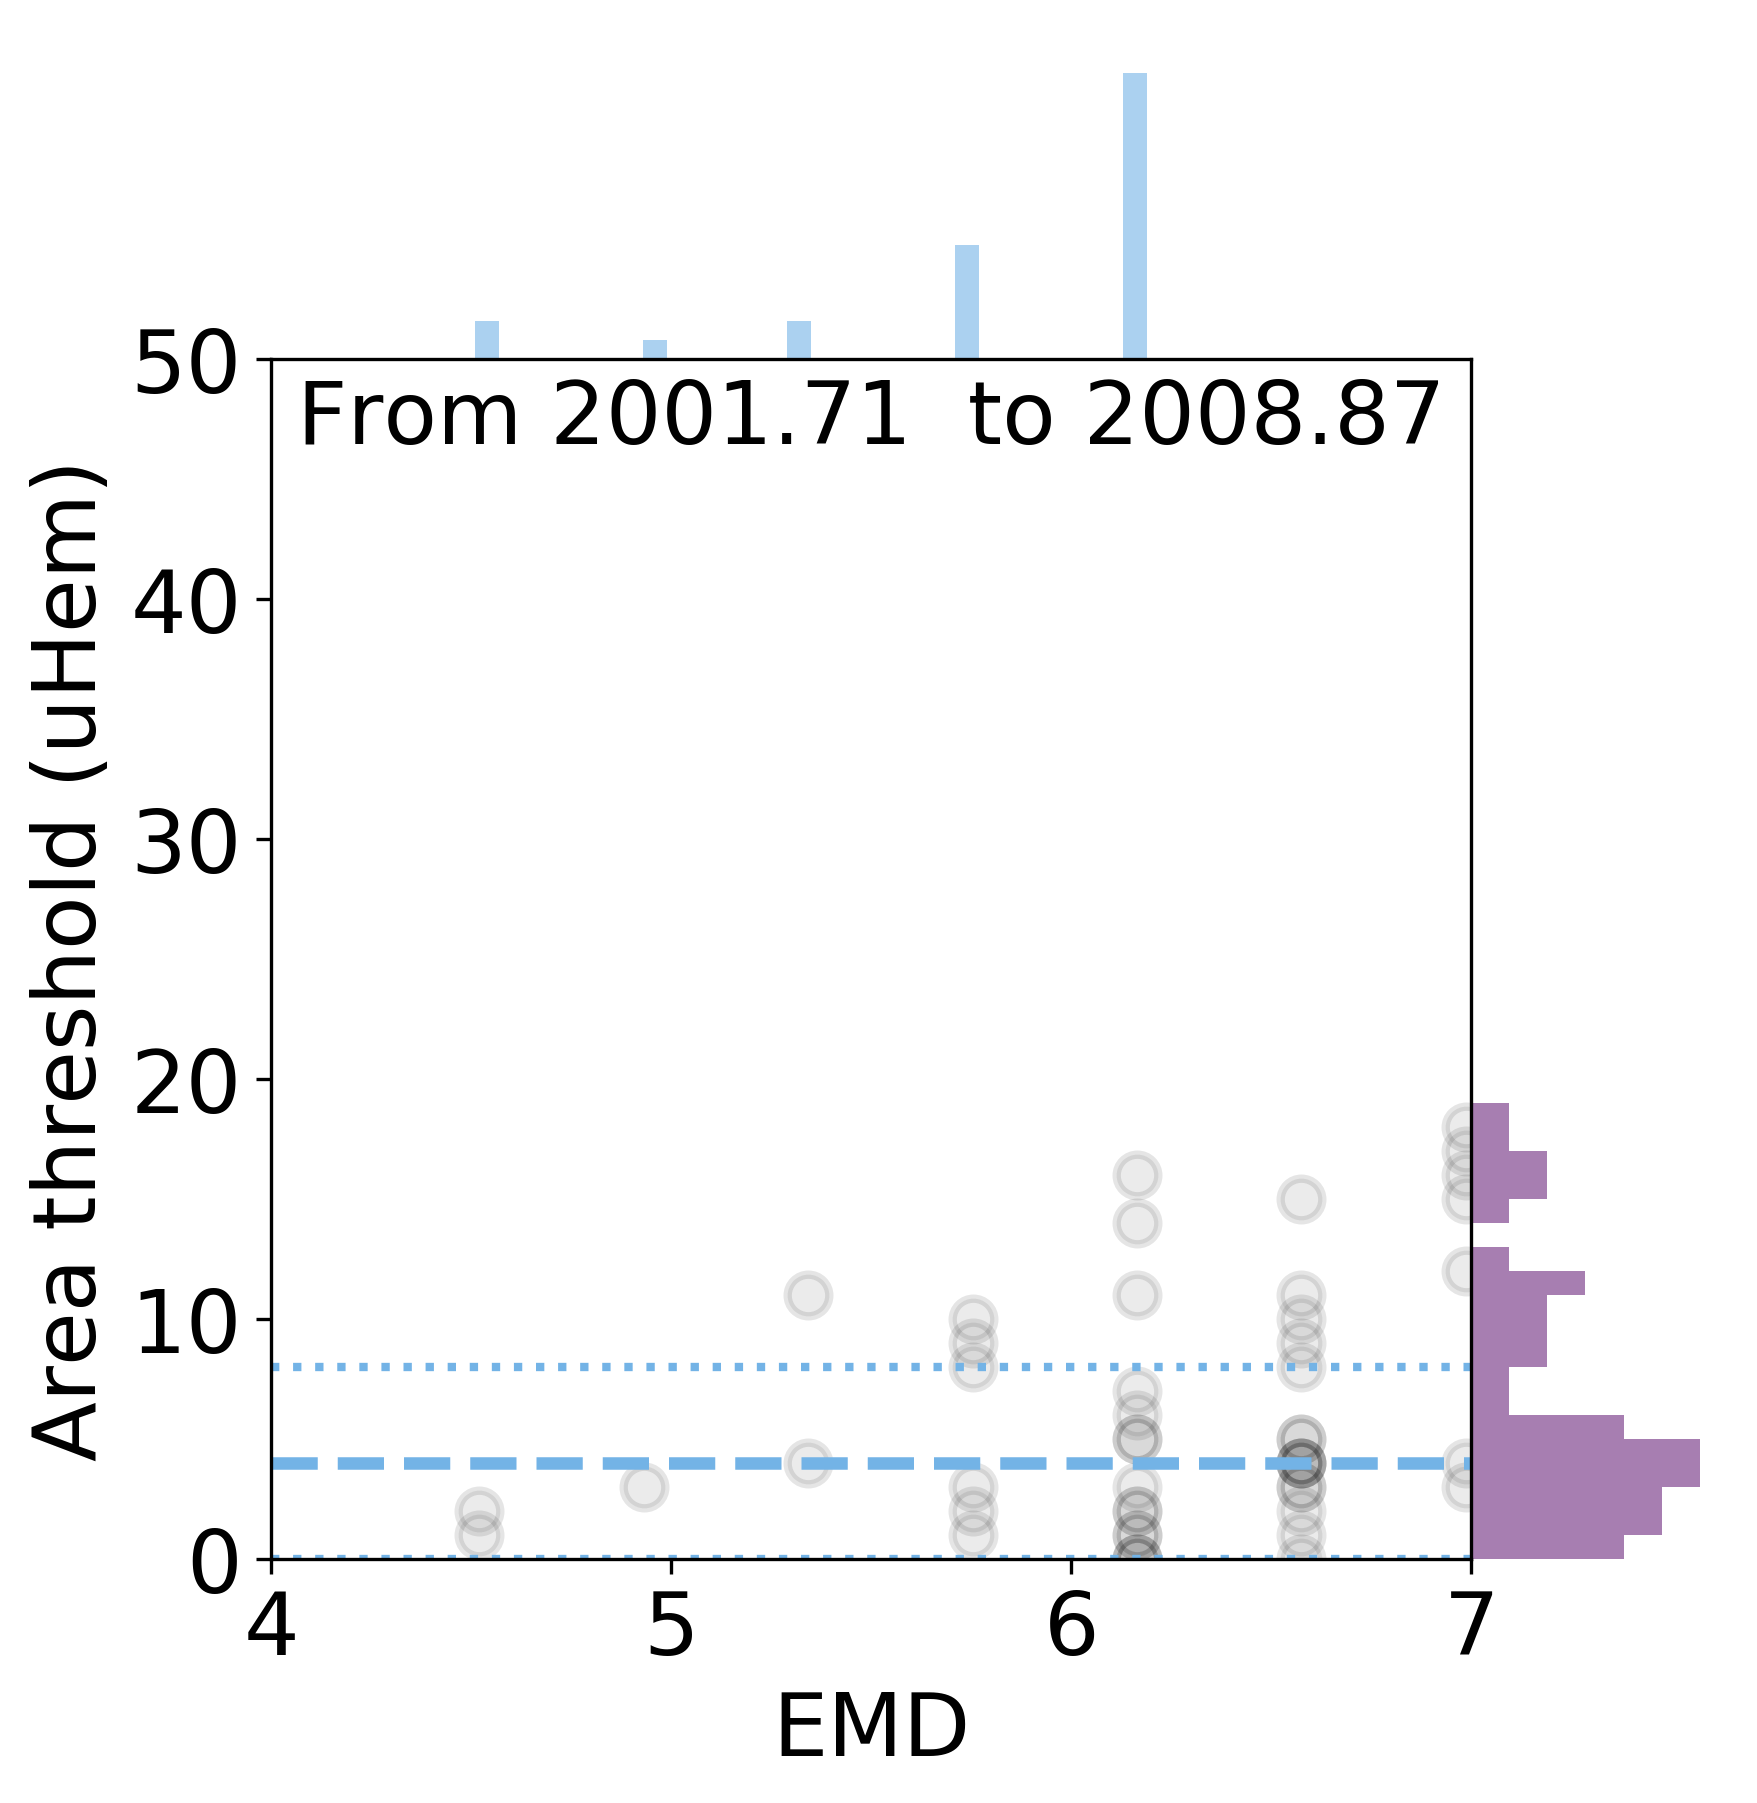

In [23]:
# Variables to store the mean threshold and its standard deviation
wAvI = vldIntr.copy()*0
wSDI = wAvI.copy()

# Distribution Plots of EMD thresholds for different intervals
# Size definitions
dpi = 300
pxx = 1500   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels 
npv = int(np.ceil(vldIntr.shape[0]/nph))      # Number of vertical panels 

# Padding
padv  = 50   #Vertical padding in pixels
padv2 = 100  #Vertical padding in pixels between panels
padh  = 50   #Horizontal padding in pixels at the edge of the figure
padh2 = 100  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)
for i in range(0, nph):
    for j in range(0,npv):
                
        n = (nph*(j)+i)
        
        # Only add the panel if it exists 
        if n<vldIntr.shape[0]:

            # Plot only if the period is valid
            if vldIntr[n]:

                # Top Distribution
                axd = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) , ppadv + j*(pxy/fszv+ppadv2) + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)], label= 'a'+str(n))
                axd.hist(bestTh[n][:,2], bins= (np.arange(0,42)-0.5)/nBest*(np.ceil(np.max(bestTh[n][:,2]))-np.floor(np.min(bestTh[n][:,2])))
                         +np.floor(np.min(bestTh[n][:,2])),  color=Clr[4], alpha=.6, normed = True);

                # Axes properties
                axd.set_xlim(left = np.floor(np.min(bestTh[n][:,2])), right = np.ceil(np.max(bestTh[n][:,2])))
                axd.set_axis_off()


                # Right Distribution
                ax2 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2) + pxx/fszh*frc, ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc*(1-frc), pxy/fszv*frc], label= 'b'+str(n))
                ax2.hist(bestTh[n][:,1], bins = np.arange(0,thN,thN/nBest)*thI,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);

                # # Axes properties
                ax2.set_ylim(bottom = 0, top = thN*thI)
                ax2.set_axis_off()

                # Scatter Plot
                ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], sharex=axd, label= 'b'+str(n))
                ax1.scatter(bestTh[n][:,2], bestTh[n][:,1], color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)

                # Constructing weights
                alph = 1-(bestTh[n][:,2]-np.min(bestTh[n][:,2]))/(np.max(bestTh[n][:,2])-np.min(bestTh[n][:,2]))

                # Weighted average
                wAvI[n] = np.sum(np.multiply(alph,bestTh[n][:,1]))/np.sum(alph)

                # Weighted Standard Deviation
                wSDI[n] = np.sqrt(np.sum(np.multiply(alph,np.power(bestTh[n][:,1]-wAvI[n],2)))/np.sum(alph))

                ax1.plot(np.array([np.floor(np.min(bestTh[n][:,2])), np.ceil(np.max(bestTh[n][:,2]))]), np.array([1,1])*wAvI[n], '--'
                         , color = Clr[4], linewidth = 3)
                ax1.plot(np.array([np.floor(np.min(bestTh[n][:,2])), np.ceil(np.max(bestTh[n][:,2]))]), np.array([1,1])*wAvI[n]-wSDI[n], ':'
                         , color = Clr[4], linewidth = 2)
                ax1.plot(np.array([np.floor(np.min(bestTh[n][:,2])), np.ceil(np.max(bestTh[n][:,2]))]), np.array([1,1])*wAvI[n]+wSDI[n], ':'
                         , color = Clr[4], linewidth = 2)

                # Axes properties
                ax1.set_ylabel('Area threshold (uHem)')
                ax1.set_xlabel('EMD')
                ax1.text(0.5, 0.95,'From ' + str(np.round(endPoints[n, 0],decimals=2)) + '  to ' + str(np.round(endPoints[n+1, 0],decimals=2)) , horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)
                ax1.set_xlim(left = np.floor(np.min(bestTh[n][:,2])), right = np.ceil(np.max(bestTh[n][:,2])))
                ax1.set_ylim(bottom = 0, top = thN*thI);

FIGURE: Each panel shows a scatterplot of the optimal EMD distance vs. optimal thresholds, as well as their marginal distributions for each valid interval separately. The thick blue line shows the average threshold weighted by distance and the thin blue lines show its weighted standard deviation. Invalid intervals are blank.


## Scatterplot of Overlapping Reference and Calibrated days using only days during valid intervals

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in greater


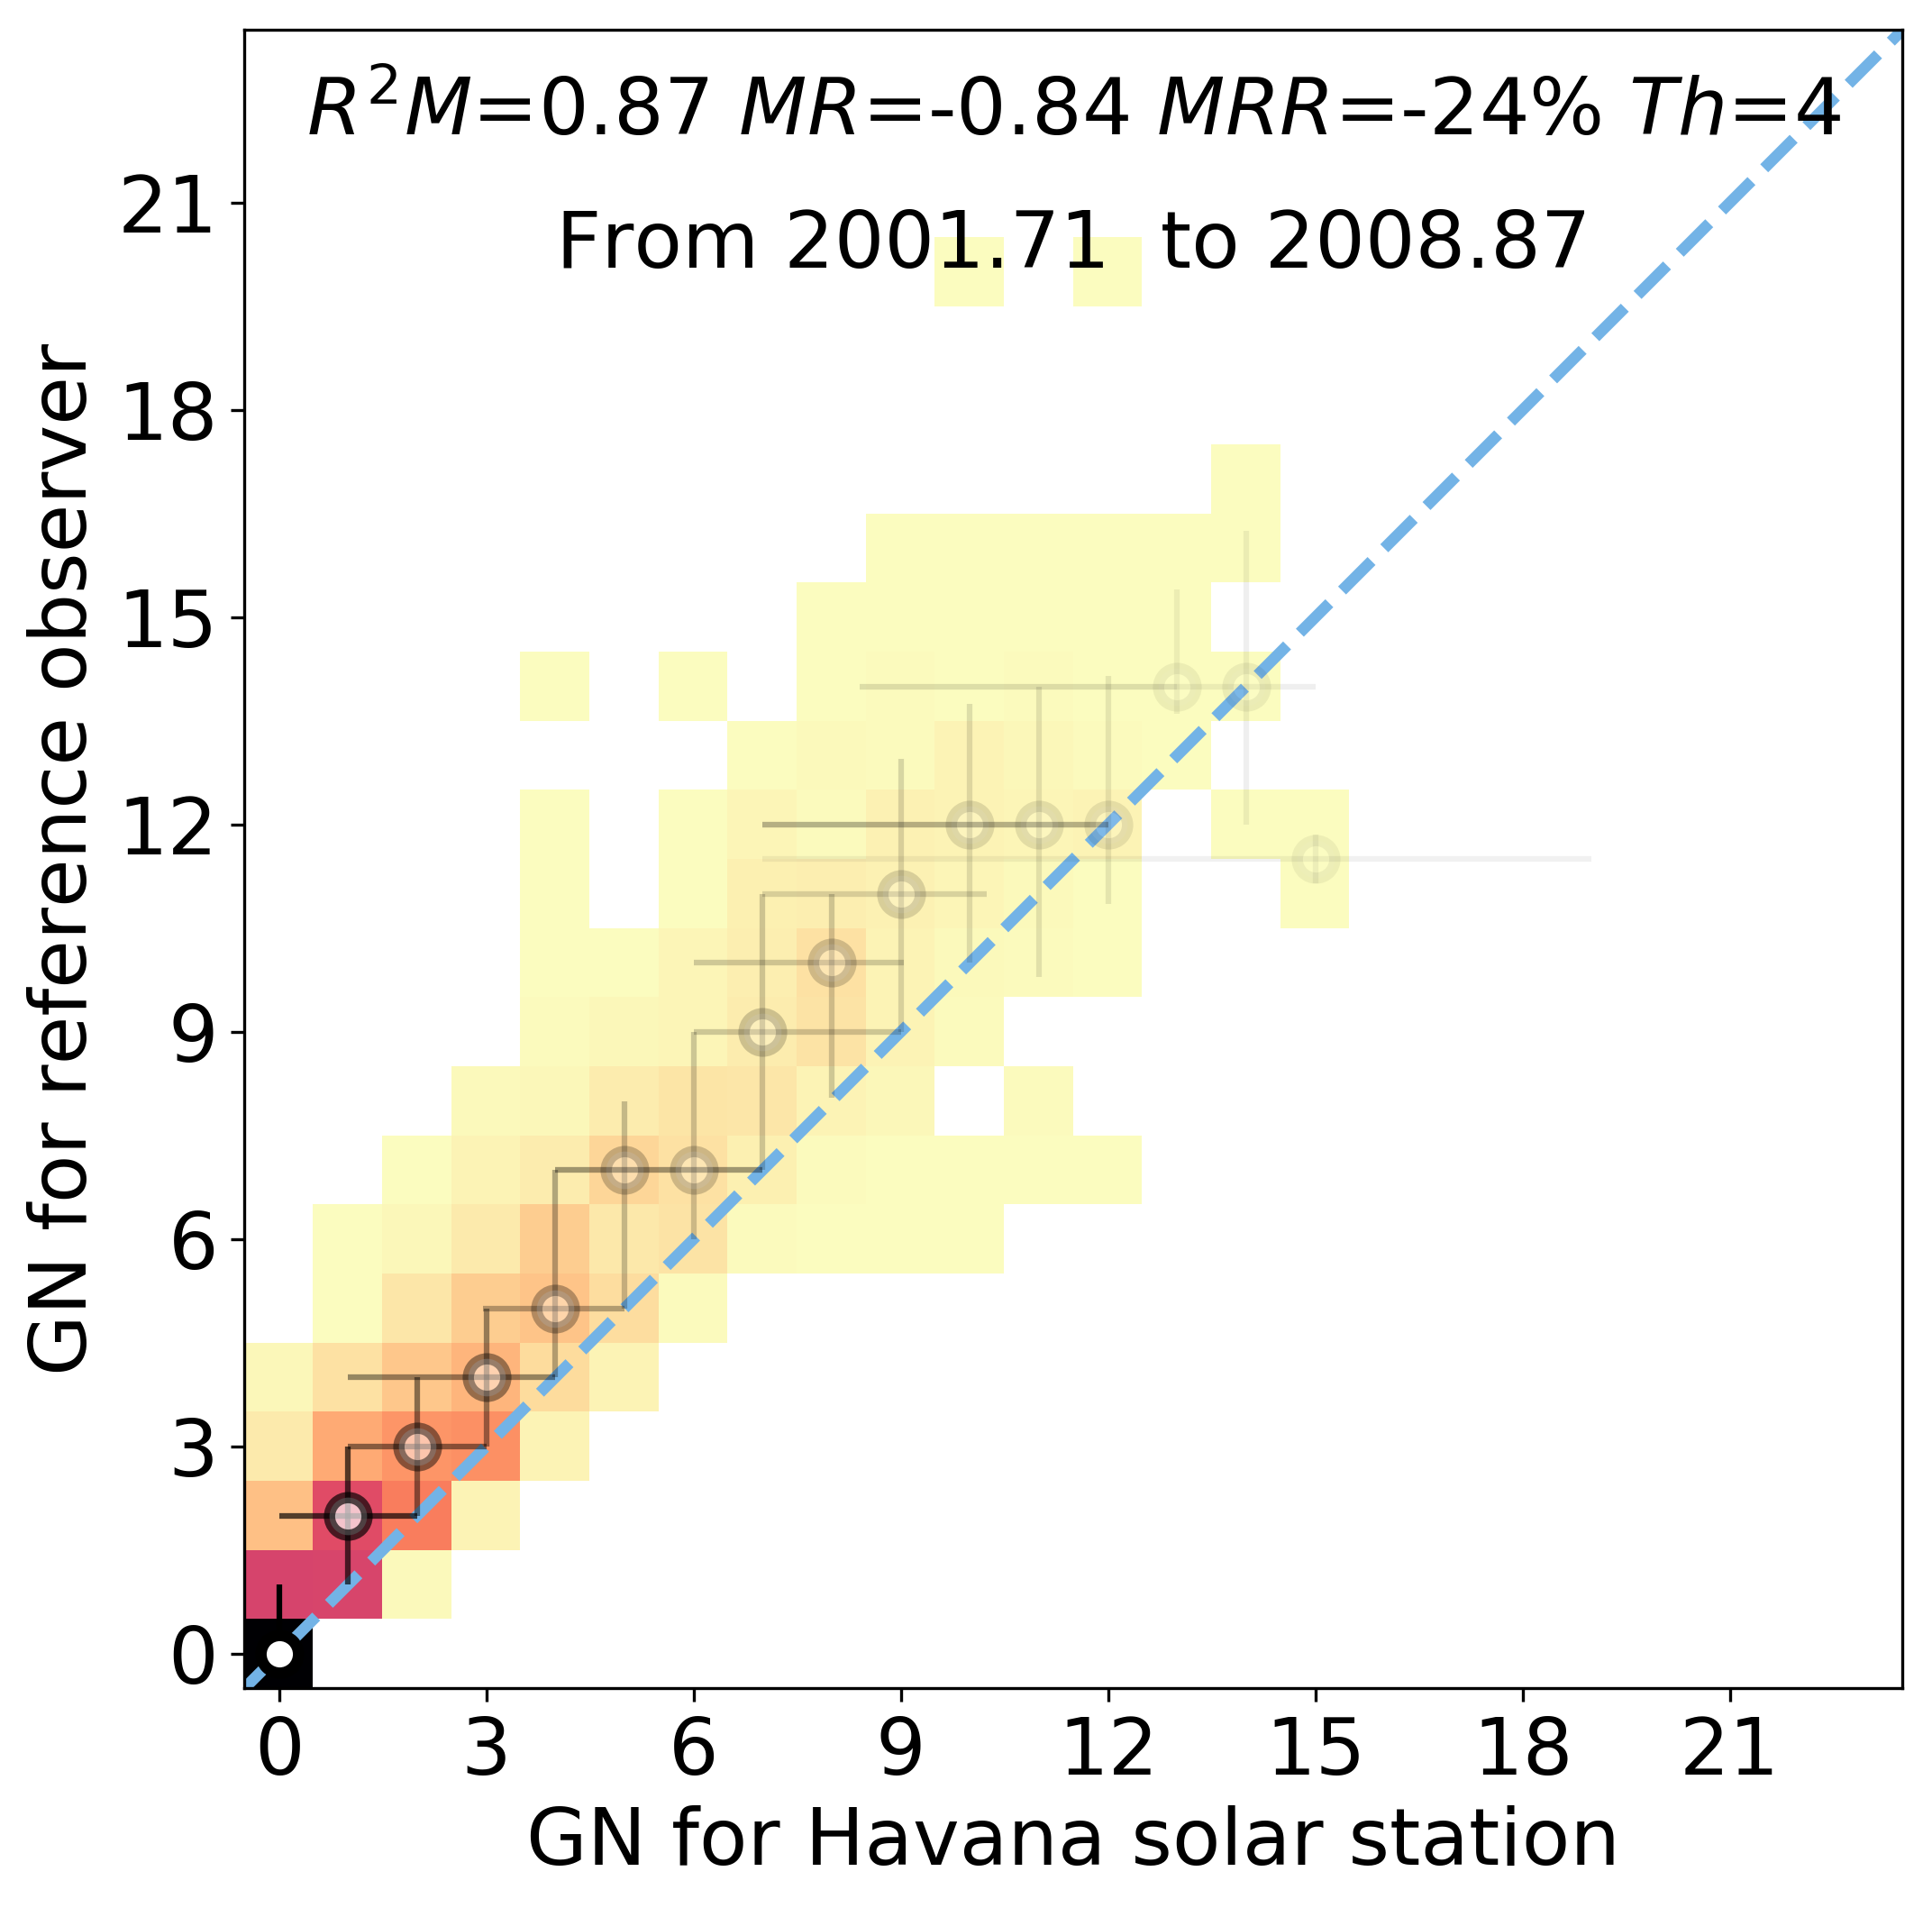

In [44]:
#Flag that activates sqrt(GN + 1)
SqrtF = False

calRef = np.array([0])
calObs = np.array([0])


# Size definitions
dpi = 300
pxx = 2300   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 3      # Number of horizontal panels        
npv = int(np.ceil(vldIntr.shape[0]/nph))      # Number of vertical panels  

# Padding
padv  = 50   #Vertical padding in pixels
padv2 = 100  #Vertical padding in pixels between panels
padh  = 50   #Horizontal padding in pixels at the edge of the figure
padh2 = 100  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Calculating maximum for plotting
maxNPlt = 0
# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    # Perform analysis Only if the period is valid
    if vldIntr[siInx]:
        TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx, 0],ObsDat['FRACYEAR']<endPoints[siInx+1, 0])
                         ,'GROUPS'].values.copy()
        TObsREFDat = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAvI[siInx]) ,axis = 1).astype(float)
        TObsREFDat = TObsREFDat[np.logical_and(REF_Dat['FRACYEAR']>=endPoints[siInx, 0],REF_Dat['FRACYEAR']<endPoints[siInx+1, 0])].copy()
        maxNPlt = np.max([np.nanmax(TObsREFDat),np.nanmax(TObsDat), maxNPlt])

        
for i in range(0, nph):
    for j in range(0,npv):
                
        n = (nph*(j)+i)
        
        # Only add the panel if it exists 
        if n<vldIntr.shape[0]:

            # Plot only if the period is valid and has overlap
            if vldIntr[n] and np.sum(np.logical_and(REF_Dat['FRACYEAR']>=endPoints[n, 0],REF_Dat['FRACYEAR']<endPoints[n+1, 0]))>0:
                
                # Calculating number of groups in reference data for given threshold
                grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAvI[n]) ,axis = 1).astype(float)
                grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan

                # Selecting observer's interval
                TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                     ,'GROUPS'].values.copy()
                TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                     ,'ORDINAL'].values.copy()
                
                # Selecting the days of overlap with calibrated observer
                grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, TObsOrd)]
                grpsObsw = TObsDat[np.in1d(TObsOrd, REF_Dat['ORDINAL'].values)]

                # Removing NaNs    
                grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
                grpsObsw = grpsObsw[np.isfinite(grpsObsw)]

                grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
                grpsREFw = grpsREFw[np.isfinite(grpsREFw)]

                # Appending to calibrated arrays?
                calRef = np.append(calRef,grpsREFw)
                calObs = np.append(calObs,grpsObsw)
                

                # Average group number 
                ax1 = fig.add_axes([ppadh + i*(pxx/fszh+ppadh2), ppadv + j*(pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv*frc], label= 'b'+str(n))

                plotHistSqrtSSN(ax1, grpsREFw, grpsObsw, np.round(wAvI[n],decimals=1), maxNPlt, SqrtF)

                ax1.text(0.5, 0.87,'From ' + str(np.round(endPoints[n, 0],decimals=2)) + '  to ' + str(np.round(endPoints[n+1, 0],decimals=2)) , horizontalalignment='center', verticalalignment='center',transform=ax1.transAxes)


FIGURE: Each panel shows a scatterplot of the Observer vs. the reference after applying the optimal threshold obtained in the step above. Each valid interval is done separately and only if it has overlap with the reference. Behind the scatterplot is show a color 2D histogram showing the number of points in each block. The faint dots also indicate less counts. Invalid intervals are blank.

# Simultaneous Optimization of Thresholds for All Sub-Intervals
The reason behind the division of the observer in sub-intervals is to allow for sequences combining cycles of various strengths that may have been observed outside the reference period, but not in the last 100 years. However, fitting each sub-interval separately suffers from reduced statistics. To address that, we perform simultaneous fits for all sub-interval by specifying a threshold, but letting each sub-interval's shift be freely optimized.


## Calculating the minimum distance for each sub-interval and each shift to identify shifts we could ignore
Using combinations of all possible shifts results in a large, unmanageable, amount of possibilities. For this reason, for each sub-interval we limit the search to their best shifts defined using the minimum distance for each shift including all thresholds and capped at disThres times the best distance for each sub-interval (see below)

Number of valid combinations: 3
[3]


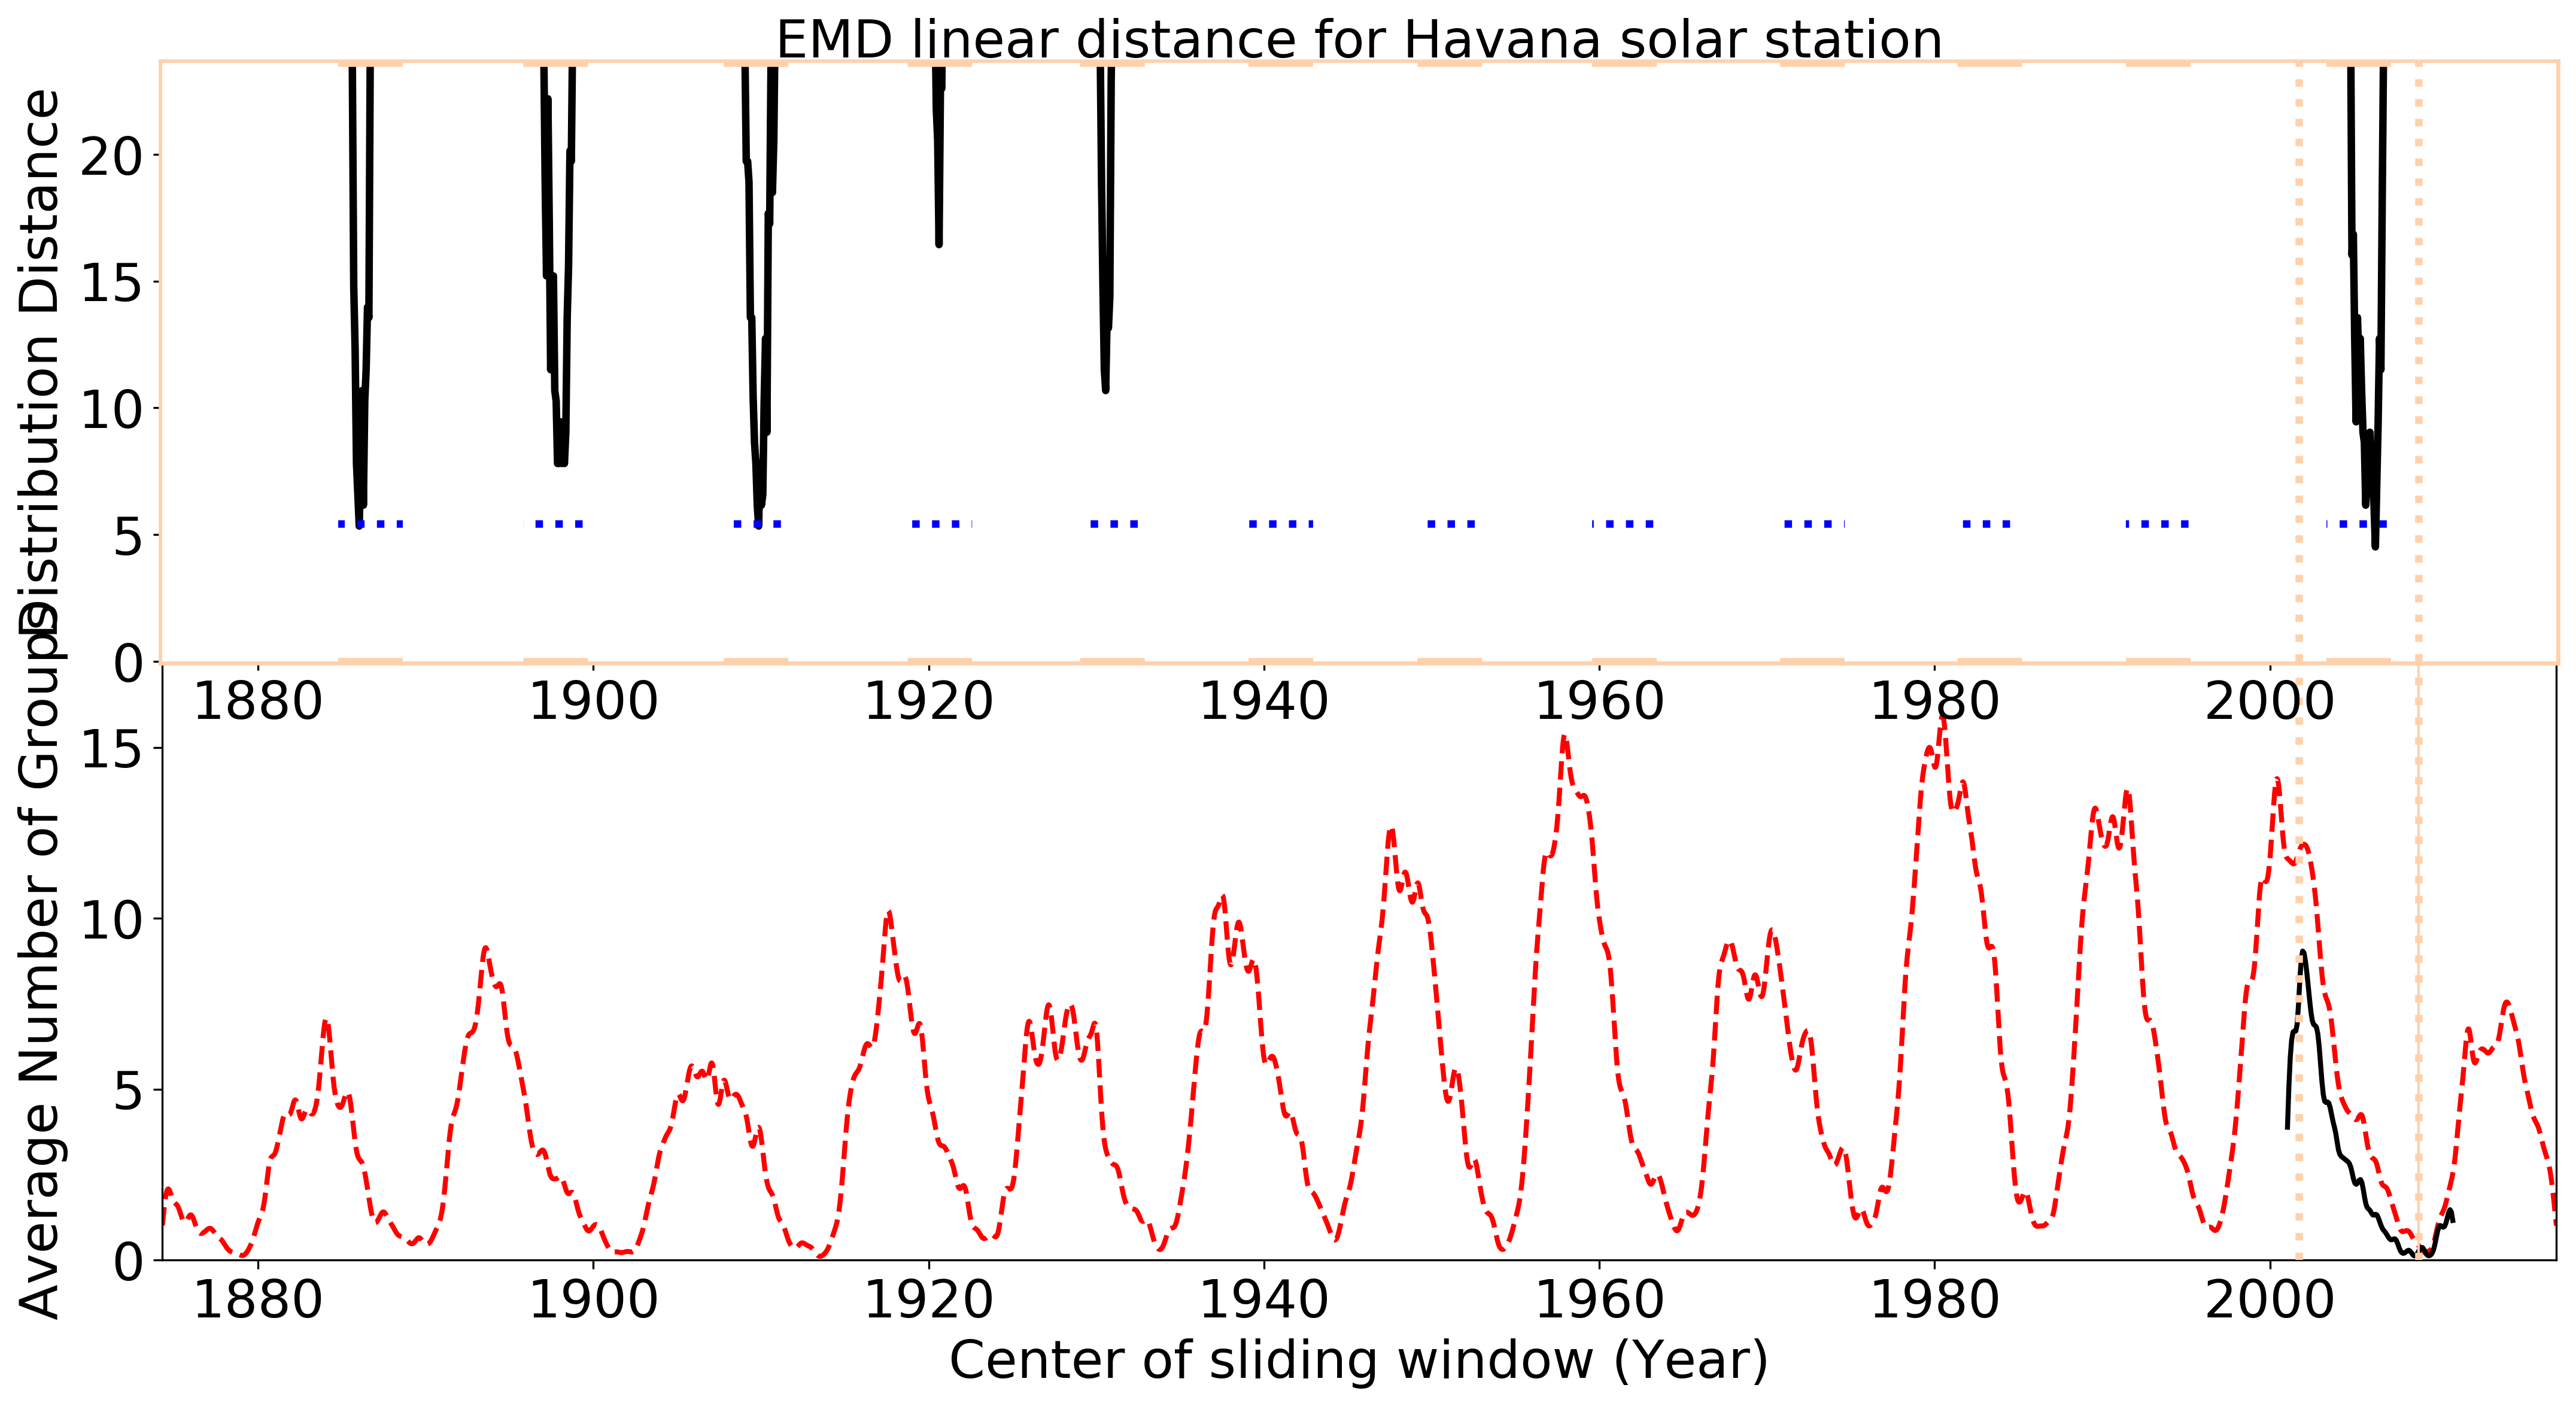

In [25]:
# Threshold above which we will ignore timeshifts (in units of the shortest 
# distance between observer and reference ADFs for each sub-interval separately)
disThres = 1.20

# Dictionary that will store valid shift indices for each sub-interval
valShfInx = []

# Dictionary that will store the length of the index array for each sub-interval
valShfLen = []

# Size definitions
dpi = 300
pxx = 4000    # Horizontal size of each panel
pxy = 1000    # Vertical size of each panel           


nph = 1                       # Number of horizontal panels
npv = cenPoints.shape[0]+1    # Number of vertical panels  

# Padding
padv  = 30 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 30 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1)

# Plotting Observer
pltx = (fyr1Ob+fyr2Ob)/2 
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2)


# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)


# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    # Defining mask based on the interval type
    if cenPoints[siInx, 1] > 0:
        cadMaskI = risMaskI
        cadMask  = risMaskP
    else:
        cadMaskI = decMaskI
        cadMask  = decMaskP
        
    # Creating axis
    ax1 = fig.add_axes([ppadh, ppadv + (siInx+1)*(pxy/fszv+ppadv2), pxx/fszh, pxy/fszv])
    
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx,0],ObsDat['FRACYEAR']<endPoints[siInx+1,0])
                         ,'FRACYEAR'].values.copy()  
    
    # Plot only if period is valid
    if vldIntr[siInx]:           
                
        # Calculating minimum distance for plotting
        x = REF_Grp['FRACYEAR'].values[cadMaskI] 
        y = np.amin(EMDD[siInx],axis=0) 
        
        # Appending valid indices to variable and storing length
        valShfInx.append((y<=disThres*np.min(y)).nonzero()[0])
        valShfLen.append(valShfInx[siInx].shape[0])

        # Plotting Optimization Matrix
        ax1.plot(x,y, color = 'k', linewidth = 3) 
        
        # Masking Gaps
        pltMsk  = np.logical_not(cadMask)
        ax1.fill_between(REF_Grp['FRACYEAR'],  REF_Grp['FRACYEAR']*0, y2=REF_Grp['FRACYEAR']*0+np.min(y)*10, where=pltMsk, color = 'w', zorder=10)        
    
        # Plotting possible theshold
        ax1.plot(np.array([np.min(x),np.max(x)]),np.array([1,1])*disThres*np.min(y), 'b:', linewidth = 3)
    
    # If period is not valid append ones so that they don't add to the permutations
    else:
        valShfInx.append(1)
        valShfLen.append(1)
        
    # Plotting edges
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,np.max(y)]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])        
    
    # Axes properties
    ax1.set_ylabel('Distribution Distance')
    ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
    ax1.set_ylim(bottom = 0, top = np.min(y)*5+1)
    
    ax1.spines['bottom'].set_color(Clr[5-siInx])
    ax1.spines['bottom'].set_linewidth(3) 
    ax1.spines['top'].set_color(Clr[5-siInx]) 
    ax1.spines['top'].set_linewidth(3) 
    ax1.spines['right'].set_color(Clr[5-siInx])
    ax1.spines['right'].set_linewidth(3) 
    ax1.spines['left'].set_color(Clr[5-siInx])
    ax1.spines['left'].set_linewidth(3)     
    
    # Adding title
    if siInx==cenPoints.shape[0]-1:
        #ax1.text(0.5, 1.01,'Chi-Square (y-y_exp)^2/(y^2+y_exp^2) for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)
        ax1.text(0.5, 1.01,'EMD linear distance for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes)

# Saving lengths as array
valShfLen = np.array(valShfLen)

print('Number of valid combinations:', np.nanprod(valShfLen))
print(valShfLen)

FIGURE: Bottom: Reference average number of groups (red). True location of the observer groups (black). Observer sub-intervals (vertical dotted lines).

Top panels: Each panel shows the smallest EMD distance of all possible thresholds for a given window shift. The dotted blue lines indicate the upper threshold used to to determine the possible shifts that will be combined in the simultaneous fit. Invalid intervals are blank.

## Defining Functions to Iterate Over All Possible Combinations

In [26]:
from copy import copy

def mrange(min_values, max_values=None):
    '''
        Inputs: min_values, a list/tuple with the starting values
                    if not given, assumed to be zero
                max_values: a list/tuple with the ending values
        outputs: a tuple of values
    '''
    
    if not max_values:
        max_values = min_values
        min_values = [0 for i in max_values]
    indices_list = copy(min_values)

    #Yield the (0,0, ..,0) value
    yield tuple(indices_list)
    
    while(True):
        indices_list = updateIndices(indices_list, min_values, max_values)
        if indices_list:
            yield tuple(indices_list)
        else:
            break#We're back at the beginning
   
def updateIndices(indices_list, min_values, max_values):
    '''
        Update the list of indices
    '''
    for index in range(len(indices_list)-1, -1, -1):
        
        #If the indices equals the max values, the reset it and 
        #move onto the next value
        if not indices_list[index] == max_values[index] - 1:
            indices_list[index] += 1
            return indices_list
        else:
            indices_list[index] = min_values[index]
    return False

## Doing simultaneous fitting of all intervals by prescribing a common threshold but allowing for any combination of shifts
In order to keep memory requirements manageable we only keep the top nBest matches.

In [27]:
# Allocating variable to store top matches
EMDComb = np.ones((cenPoints.shape[0]+2,nBest))*10000 

# Identify first valid index
fstVldIn = vldIntr.nonzero()[0][0]

print('start', datetime.datetime.now(), '0 of', valShfLen[fstVldIn]-1) 

comProg = 0
for comb in mrange(valShfLen): 
    
    # Inform user of progress
    if comb[fstVldIn]!=comProg:
        print(comb[fstVldIn], 'of', valShfLen[fstVldIn]-1, 'at', datetime.datetime.now())
        comProg = comb[fstVldIn]        
        
    # Going through different thresholds for a given combination of shifts
    for TIdx in range(0,thN):
        
        # Initializing arrays for joining the ADFs of all sub-intervals
        ADFObsII = np.array([])
        ADFREFII = np.array([])
        
        # Joining ADF from all sub-interval for the specified shifts
        for siInx in range(0,cenPoints.shape[0]):
            
            # Append only if period is valid
            if vldIntr[siInx]: 
            
                # If it is the first interval re-create the arrays
                if ADFObsII.shape[0] == 0:                 
                    ADFObsII = ADFObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]
                    
                    ADFREFII = ADFREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD]
                    
                # If not, append ADF from all sub-interval for the specified shifts
                else:                    
                    ADFObsII = np.append(ADFObsII,ADFObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODObsI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD])
                    
                    ADFREFII = np.append(ADFREFII,ADFREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],ODREFI[siInx][TIdx,valShfInx[siInx][comb[siInx]],:]/MoLngt>=minObD])
                    
        # Calculating Earth Mover's Distance
        ADFObsDis, bins = np.histogram(ADFObsII, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        ADFREFDis, bins = np.histogram(ADFREFII, bins= (np.arange(0,MoLngt+2)-0.5)/MoLngt, density = True)
        tmpEMD = emd(ADFREFDis.astype(np.float64),ADFObsDis.astype(np.float64),Dis.astype(np.float64))
        
        if np.any(EMDComb[0,:]>tmpEMD):
            
            # Determining index for insertion
            insInx = nBest-np.sum(EMDComb[0,:]>=tmpEMD)
            
            # Initializing array to be inserted
            insArr = [tmpEMD,TIdx]
            
            # Append shifts
            for siInx in range(0,cenPoints.shape[0]):
                
                # Append only if period is valid
                if vldIntr[siInx]:                
                    insArr.append(valShfInx[siInx][comb[siInx]])
                # If not, append dummy    
                else:
                    insArr.append(np.nan)
            
            # Convert to numpy array
            insArr = np.array(insArr)
            
            # Insert values
            EMDComb = np.insert(EMDComb, insInx, insArr, axis=1)
            
            # Remove last element
            EMDComb = EMDComb[:,0:nBest]
            

start 2018-09-25 12:45:01.261113 0 of 2
1 of 2 at 2018-09-25 12:45:01.317112
2 of 2 at 2018-09-25 12:45:01.360137


## Plot Location and Threshold of Best Matches

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


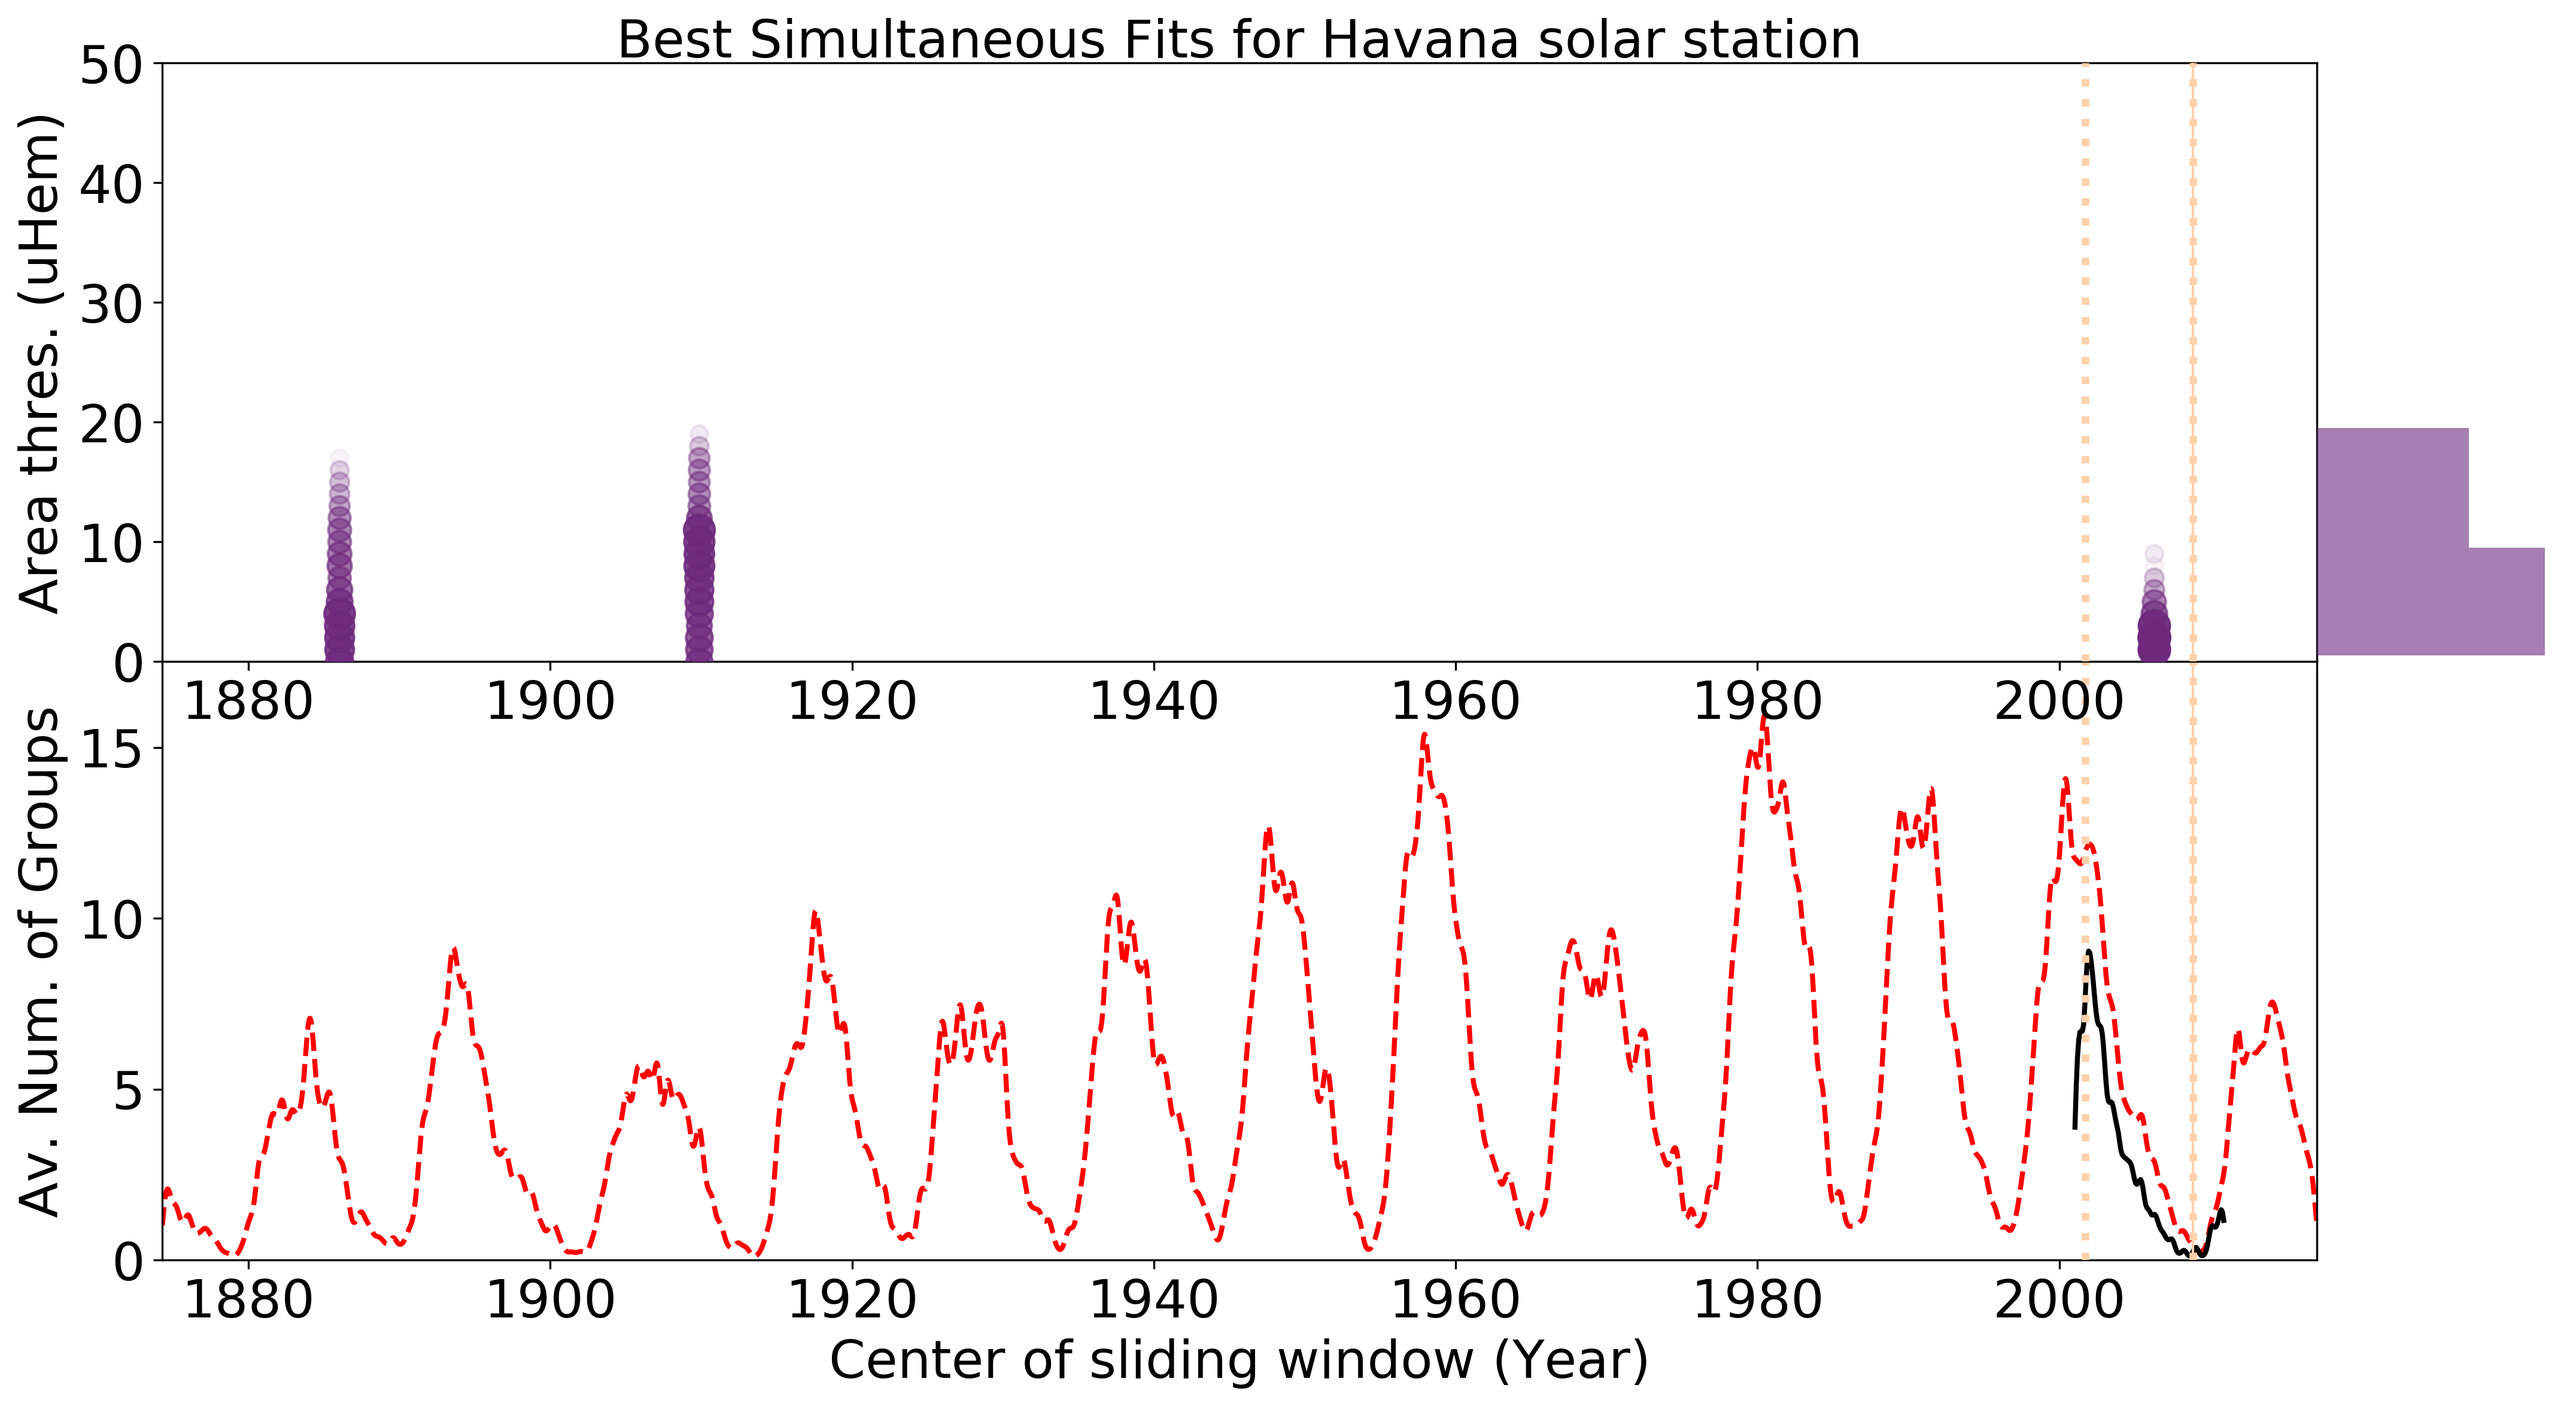

In [28]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1000   # Vertical size of each panel
frc = 0.9    # Fraction of the panel devoted to histogram

nph = 1    # Number of horizontal panels
npv = 2    # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)

# Comparison with RGO
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv])
ax2.plot(REF_Grp['FRACYEAR'],REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1)

# Plotting Observer
pltx = (fyr1Ob+fyr2Ob)/2 
ax2.plot(pltx, AvGrpOb, color = Clr[0], linewidth = 2) 

# Axes properties
ax2.set_ylabel('Av. Num. of Groups')
ax2.set_xlabel('Center of sliding window (Year)')
ax2.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']));
ax2.set_ylim(bottom = 0, top = np.max(REF_Grp['AVGROUPS'])*1.1)


# Placement of top simultaneous fits
ax1 = fig.add_axes([ppadh, ppadv + (pxy/fszv+ppadv2), pxx/fszh*frc, pxy/fszv])


# Going through different sub-intervals
for siInx in range(0,cenPoints.shape[0]):
    
    TObsFYr = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[siInx,0],ObsDat['FRACYEAR']<endPoints[siInx+1,0])
                         ,'FRACYEAR'].values.copy()      
   
    # Plotting edges
    ax1.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax1.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    ax2.plot(np.array([1,1])*np.min(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),'-', zorder=11, linewidth = 1, color = Clr[5-siInx])
    ax2.plot(np.array([1,1])*np.max(TObsFYr), np.array([0,thN*thI]),':', zorder=11, linewidth = 3, color = Clr[5-siInx])

    
# Define years for plotting
Year = REF_Grp['FRACYEAR'].values[cadMaskI]

for i in range(0,nBest):
    
    # Initialize plot vector
    x = np.array([])

    for siInx in range(0,cenPoints.shape[0]):
        
        # Defining mask based on the interval type (rise or decay)
        if cenPoints[siInx, 1] > 0:
            cadMaskI = risMaskI
            cadMask  = risMaskP
        else:
            cadMaskI = decMaskI
            cadMask  = decMaskP        
        
        Year = REF_Grp['FRACYEAR'].values[cadMaskI]

        # Append only if period is valid
        if vldIntr[siInx]: 
                 
            # If it is the first interval re-create the array
            if x.shape[0] == 0:
                x = np.array([Year[EMDComb[siInx+2,i].astype(np.int)]])
            # Append other sub-intervals     
            else:
                x = np.append(x,Year[EMDComb[siInx+2,i].astype(np.int)]) 
    
    # Creating matching threshold vector
    y = x*0 + EMDComb[1,i]
    
    # Constructing alpha
    alph = 1-(EMDComb[0,i]-np.min(EMDComb[0,:]))/(np.max(EMDComb[0,:])-np.min(EMDComb[0,:]))
      
    # Plotting Intervals
    ax1.plot(x, y,'o:', zorder=11, linewidth = 1, color = Clr[2], alpha = alph, markersize=(101-i)/8)
    
# Axes properties
ax1.set_ylabel('Area thres. (uHem)')
ax1.set_xlim(left = np.min(REF_Dat['FRACYEAR']), right = np.max(REF_Dat['FRACYEAR']))
ax1.set_ylim(bottom = 0, top = thN*thI)
    
ax1.text(0.5, 1.01,'Best Simultaneous Fits for ' + NamObs.capitalize(), horizontalalignment='center', transform = ax1.transAxes);


# Right Distribution
ax3 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv + (pxy/fszv+ppadv2), pxx/fszh*(1-frc), pxy/fszv])
ax3.hist(EMDComb[1,:], bins = np.arange(0,thN)*thI+thI/2,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);

# # Axes properties
ax3.set_ylim(bottom = 0, top = thN*thI)
ax3.set_axis_off()

fig.savefig(NamObs.capitalize() + '_Simultaneous_Fit_EMD.png', bbox_inches='tight', dpi = 103, pad_inches=0)


FIGURE: Bottom: Reference average number of groups (red). True location of the observer groups (black). Observer sub-intervals (vertical dotted lines).

Top: Best simultaneous fits obtained using the shifts identified above. All possible combinations are tested, but only the top nBest are displayed. Dots denote the optimal shifts and each combination of intervals is joined by a horizontal line denoting the optimal threshold. Transparency indicates EMD distance: The bolder the system the smaller the distance. The marginal distribution of thresholds is shown on the right.

## Plotting distribution of Thresholds for the simultaneous fits

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


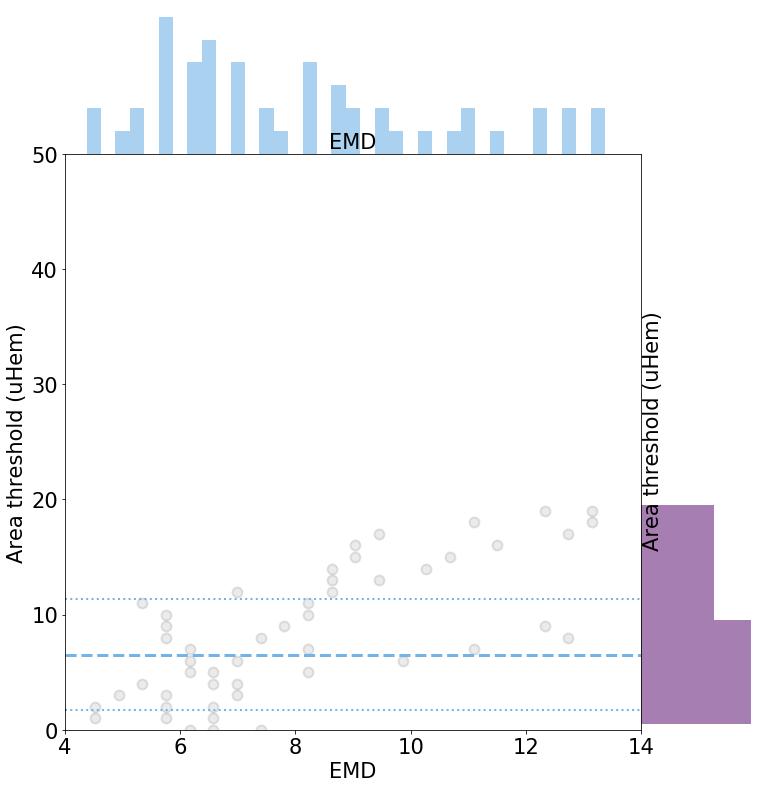

In [29]:
# Distribution Plots of threshold and distance

# Size definitions
dpi = 300
pxx = 3000   # Horizontal size of each panel
pxy = pxx    # Vertical size of each panel
frc = 0.8    # Fraction of the panel devoted to histograms

nph = 1      # Number of horizontal panels
npv = 1      # Number of vertical panels

# Padding
padv  = 50 #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))


# Top Distribution
axd = fig.add_axes([ppadh, ppadv + pxy/fszv*frc, pxx/fszh*frc, pxy/fszv*(1-frc)])
axd.hist(EMDComb[0,:], bins= (np.arange(0,42)-0.5)/40*(np.ceil(np.max(EMDComb[0,:]))-np.floor(np.min(EMDComb[0,:])))
         +np.floor(np.min(EMDComb[0,:])),  color=Clr[4], alpha=.6, normed = True);

# Axes properties
axd.set_xlim(left = np.floor(np.min(EMDComb[0,:])), right = np.ceil(np.max(EMDComb[0,:])))
axd.set_axis_off()


# Right Distribution
ax2 = fig.add_axes([ppadh + pxx/fszh*frc, ppadv, pxx/fszh*frc*(1-frc), pxy/fszv*frc])
ax2.hist(EMDComb[1,:], bins = np.arange(0,thN)*thI+thI/2,  color=Clr[2], alpha=.6, orientation = 'horizontal', normed = True);

# # Axes properties
ax2.set_ylim(bottom = 0, top = thN*thI)
ax2.set_axis_off()

# Scatter Plot
ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], sharex=axd)
ax1.scatter(EMDComb[0,:], EMDComb[1,:], color="0.25", edgecolor="k", alpha = 0.1, s=100, linewidths = 2)

# Constructing weights
alph = 1-(EMDComb[0,:]-np.min(EMDComb[0,:]))/(np.max(EMDComb[0,:])-np.min(EMDComb[0,:]))

# Weighted average
wAv = np.sum(np.multiply(alph,EMDComb[1,:]))/np.sum(alph)

# Weighted Standard Deviation
wSD = np.sqrt(np.sum(np.multiply(alph,np.power(EMDComb[1,:]-wAv,2)))/np.sum(alph))

ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv, '--'
         , color = Clr[4], linewidth = 3)
ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv-wSD, ':'
         , color = Clr[4], linewidth = 2)
ax1.plot(np.array([np.floor(np.min(EMDComb[0,:])), np.ceil(np.max(EMDComb[0,:]))]), np.array([1,1])*wAv+wSD, ':'
         , color = Clr[4], linewidth = 2)

# Axes properties
ax1.set_ylabel('Area threshold (uHem)')
ax1.text(1.02, 0.52,'Area threshold (uHem)', horizontalalignment='center', transform = ax1.transAxes, 
         rotation = 'vertical', verticalalignment = 'center')
ax1.set_xlabel('EMD')
ax1.text(0.5, 1.01,'EMD', horizontalalignment='center', transform = ax1.transAxes)
ax1.set_xlim(left = np.floor(np.min(EMDComb[0,:])), right = np.ceil(np.max(EMDComb[0,:])))
ax1.set_ylim(bottom = 0, top = thN*thI);

FIGURE: Scatterplot of the optimal EMD distance vs. optimal thresholds, as well as their marginal distributions. The thick blue line shows the average threshold weighted by distance and the thin blue lines show its weighted standard deviation.

## Scatterplot of Overlapping Reference and Calibrated days

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


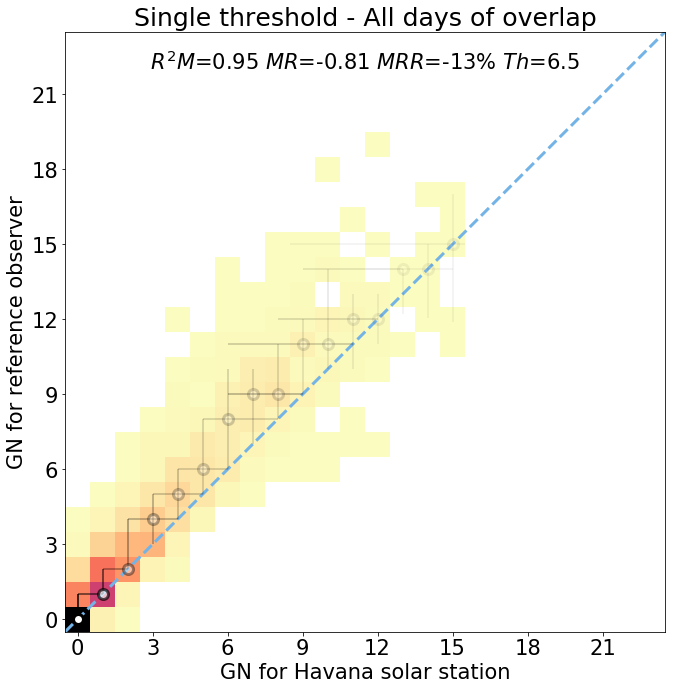

In [45]:
## Test if there is any overlap
if ( np.min(REF_Dat['ORDINAL'])<=np.min(ObsDat['ORDINAL']) ) or ( np.max(REF_Dat['ORDINAL'])>=np.max(ObsDat['ORDINAL']) ):
    
    # Calculating number of groups in reference data for given threshold
    grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAv) ,axis = 1).astype(float)
    grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan
    
    # Selecting the days of overlap with calibrated observer
    grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, ObsDat['ORDINAL'].values)]
    grpsObsw = ObsDat.loc[np.in1d(ObsDat['ORDINAL'].values, REF_Dat['ORDINAL'].values),'GROUPS'].values
    
    # Removing NaNs    
    grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
    grpsObsw = grpsObsw[np.isfinite(grpsObsw)]
    
    grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
    grpsREFw = grpsREFw[np.isfinite(grpsREFw)]
    
    plt.rc('font', **font)
    
    # Size definitions
    dpi = 300
    pxx = 2500   # Horizontal size of each panel
    pxy = pxx    # Vertical size of each panel

    nph = 1      # Number of horizontal panels
    npv = 1      # Number of vertical panels

    # Padding
    padv  = 50 #Vertical padding in pixels
    padv2 = 0  #Vertical padding in pixels between panels
    padh  = 50 #Horizontal padding in pixels at the edge of the figure
    padh2 = 0  #Horizontal padding in pixels between panels

    # Figure sizes in pixels
    fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
    fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

    # Conversion to relative unites
    ppadv  = padv/fszv     #Vertical padding in relative units
    ppadv2 = padv2/fszv    #Vertical padding in relative units
    ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
    ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))
 
    ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])
    
    plotHistSqrtSSN(ax1, grpsREFw, grpsObsw, np.round(wAv,decimals=1), maxNPlt, SqrtF) 
    
    ax1.set_title('Single threshold - All days of overlap')
   

FIGURE: Scatterplot of the Observer vs. the reference after applying the optimal threshold obtained in the step above. Behind the scatterplot is show a color 2D histogram showing the number of points in each block. The faint dots also indicate less counts.

## Scatterplot of Overlapping Reference and Calibrated days using a different threshold for each interval

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in greater


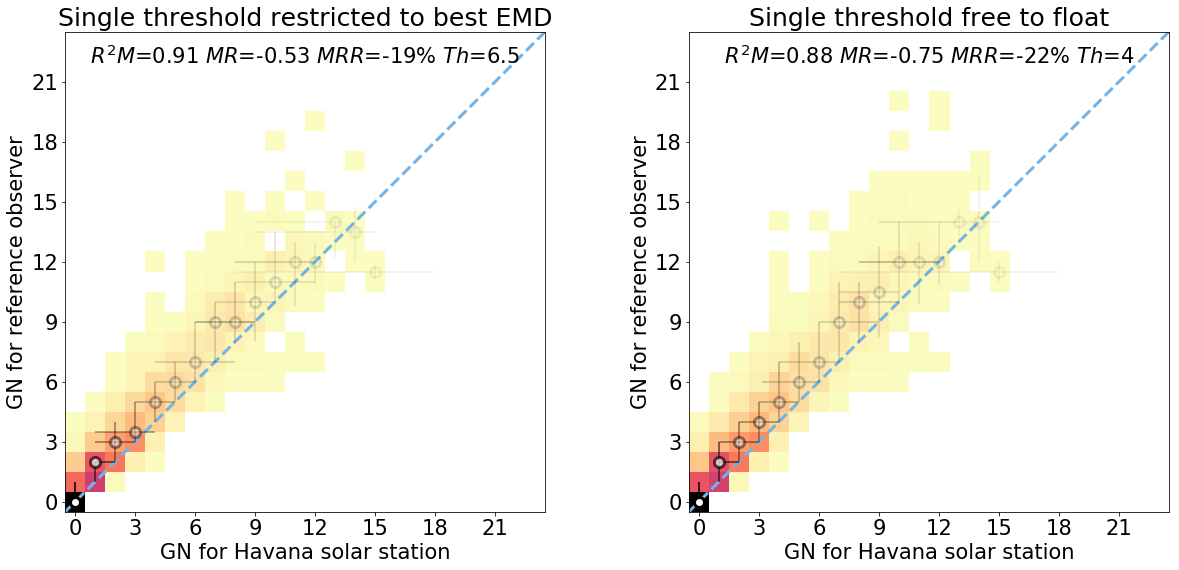

In [46]:
# Test if there is any overlap
if calRef.shape[0]>1:
            
    plt.rc('font', **font)
    
    # Size definitions
    dpi = 300
    pxx = 2500   # Horizontal size of each panel
    pxy = pxx    # Vertical size of each panel

    nph = 2      # Number of horizontal panels
    npv = 1      # Number of vertical panels

    # Padding
    padv  = 50 #Vertical padding in pixels
    padv2 = 0  #Vertical padding in pixels between panels
    padh  = 50 #Horizontal padding in pixels at the edge of the figure
    padh2 = 50 #Horizontal padding in pixels between panels

    # Figure sizes in pixels
    fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
    fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

    # Conversion to relative unites
    ppadv  = padv/fszv     #Vertical padding in relative units
    ppadv2 = padv2/fszv    #Vertical padding in relative units
    ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
    ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units
  
    calRefT = calRef.copy()
    calObsT = calObs.copy()
   
    ## Start Figure
    fig = plt.figure(figsize=(fszh/dpi,fszv/dpi))
    
    ax1 = fig.add_axes([ppadh, ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b1')

    calRefN = np.array([0])
    calObsN = np.array([0])
        
    calRefNmt = np.array([0])
    calObsNmt = np.array([0])
    
    for n in range(0,cenPoints.shape[0]):
    
        # Plot only if the period is valid and has overlap
        if vldIntr[n] and np.sum(np.logical_and(REF_Dat['FRACYEAR']>=endPoints[n, 0],REF_Dat['FRACYEAR']<endPoints[n+1, 0]))>0:

            # Calculating number of groups in reference data for given threshold
            grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAv) ,axis = 1).astype(float)
            grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan

            # Selecting observer's interval
            TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'GROUPS'].values.copy()
            TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'ORDINAL'].values.copy()

            # Selecting the days of overlap with calibrated observer
            grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, TObsOrd)]
            grpsObsw = TObsDat[np.in1d(TObsOrd, REF_Dat['ORDINAL'].values)]

            # Removing NaNs    
            grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
            grpsObsw = grpsObsw[np.isfinite(grpsObsw)]

            grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
            grpsREFw = grpsREFw[np.isfinite(grpsREFw)]

            # Appending to calibrated arrays?
            calRefN = np.append(calRefN,grpsREFw)
            calObsN = np.append(calObsN,grpsObsw)
            
            # Calculating number of groups in reference data for given the interval threshold
            grpsREFw = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAvI[n]) ,axis = 1).astype(float)
            grpsREFw[np.isnan(REF_Dat['AREA1'])] = np.nan

            # Selecting observer's interval
            TObsDat = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'GROUPS'].values.copy()
            TObsOrd = ObsDat.loc[np.logical_and(ObsDat['FRACYEAR']>=endPoints[n, 0],ObsDat['FRACYEAR']<endPoints[n+1, 0])
                                 ,'ORDINAL'].values.copy()

            # Selecting the days of overlap with calibrated observer
            grpsREFw = grpsREFw[np.in1d(REF_Dat['ORDINAL'].values, TObsOrd)]
            grpsObsw = TObsDat[np.in1d(TObsOrd, REF_Dat['ORDINAL'].values)]

            # Removing NaNs    
            grpsREFw = grpsREFw[np.isfinite(grpsObsw)]
            grpsObsw = grpsObsw[np.isfinite(grpsObsw)]

            grpsObsw = grpsObsw[np.isfinite(grpsREFw)]
            grpsREFw = grpsREFw[np.isfinite(grpsREFw)]


            # Appending to calibrated arrays
            calRefNmt = np.append(calRefN,grpsREFw)
            calObsNmt = np.append(calObsN,grpsObsw)            
            

    # Calculating goodness of fit of Y=X
    
    if np.sum(vldIntr) > 1:
        thTxt = 'Variable'
        titlTxt1 = 'Single threshold - only valid intervals'
        titlTxt2 = 'Multi-threshold - only valid intervals'
    else:
        thTxt = wAvI[vldIntr][0]
        titlTxt1 = 'Single threshold restricted to best EMD'            
        titlTxt2 = 'Single threshold free to float'    
                
    plotHistSqrtSSN(ax1, calRefN, calObsN, np.round(wAv,decimals=1), maxNPlt, SqrtF)
    
    ax1.set_title(titlTxt1)
    
    ax2 = fig.add_axes([ppadh + (pxx/fszh+ppadh2), ppadv, pxx/fszh*frc, pxy/fszv*frc], label= 'b2')

    plotHistSqrtSSN(ax2, calRefNmt, calObsNmt, thTxt, maxNPlt, SqrtF)
    
    ax2.set_title(titlTxt2)
  

FIGURE: Scatterplot of the Observer vs. the reference. As opposed to the one above, this scatter plot uses different thresholds for different intervals. The scatterplot is performed by merging all the scatterplots shown in the Figure Above

Behind the scatterplot is show a color 2D histogram showing the number of points in each block. The faint dots also indicate less counts.

## Plotting comparison the observer's group vs. RGO (total and optimal threshold) groups

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: Mean of empty slice


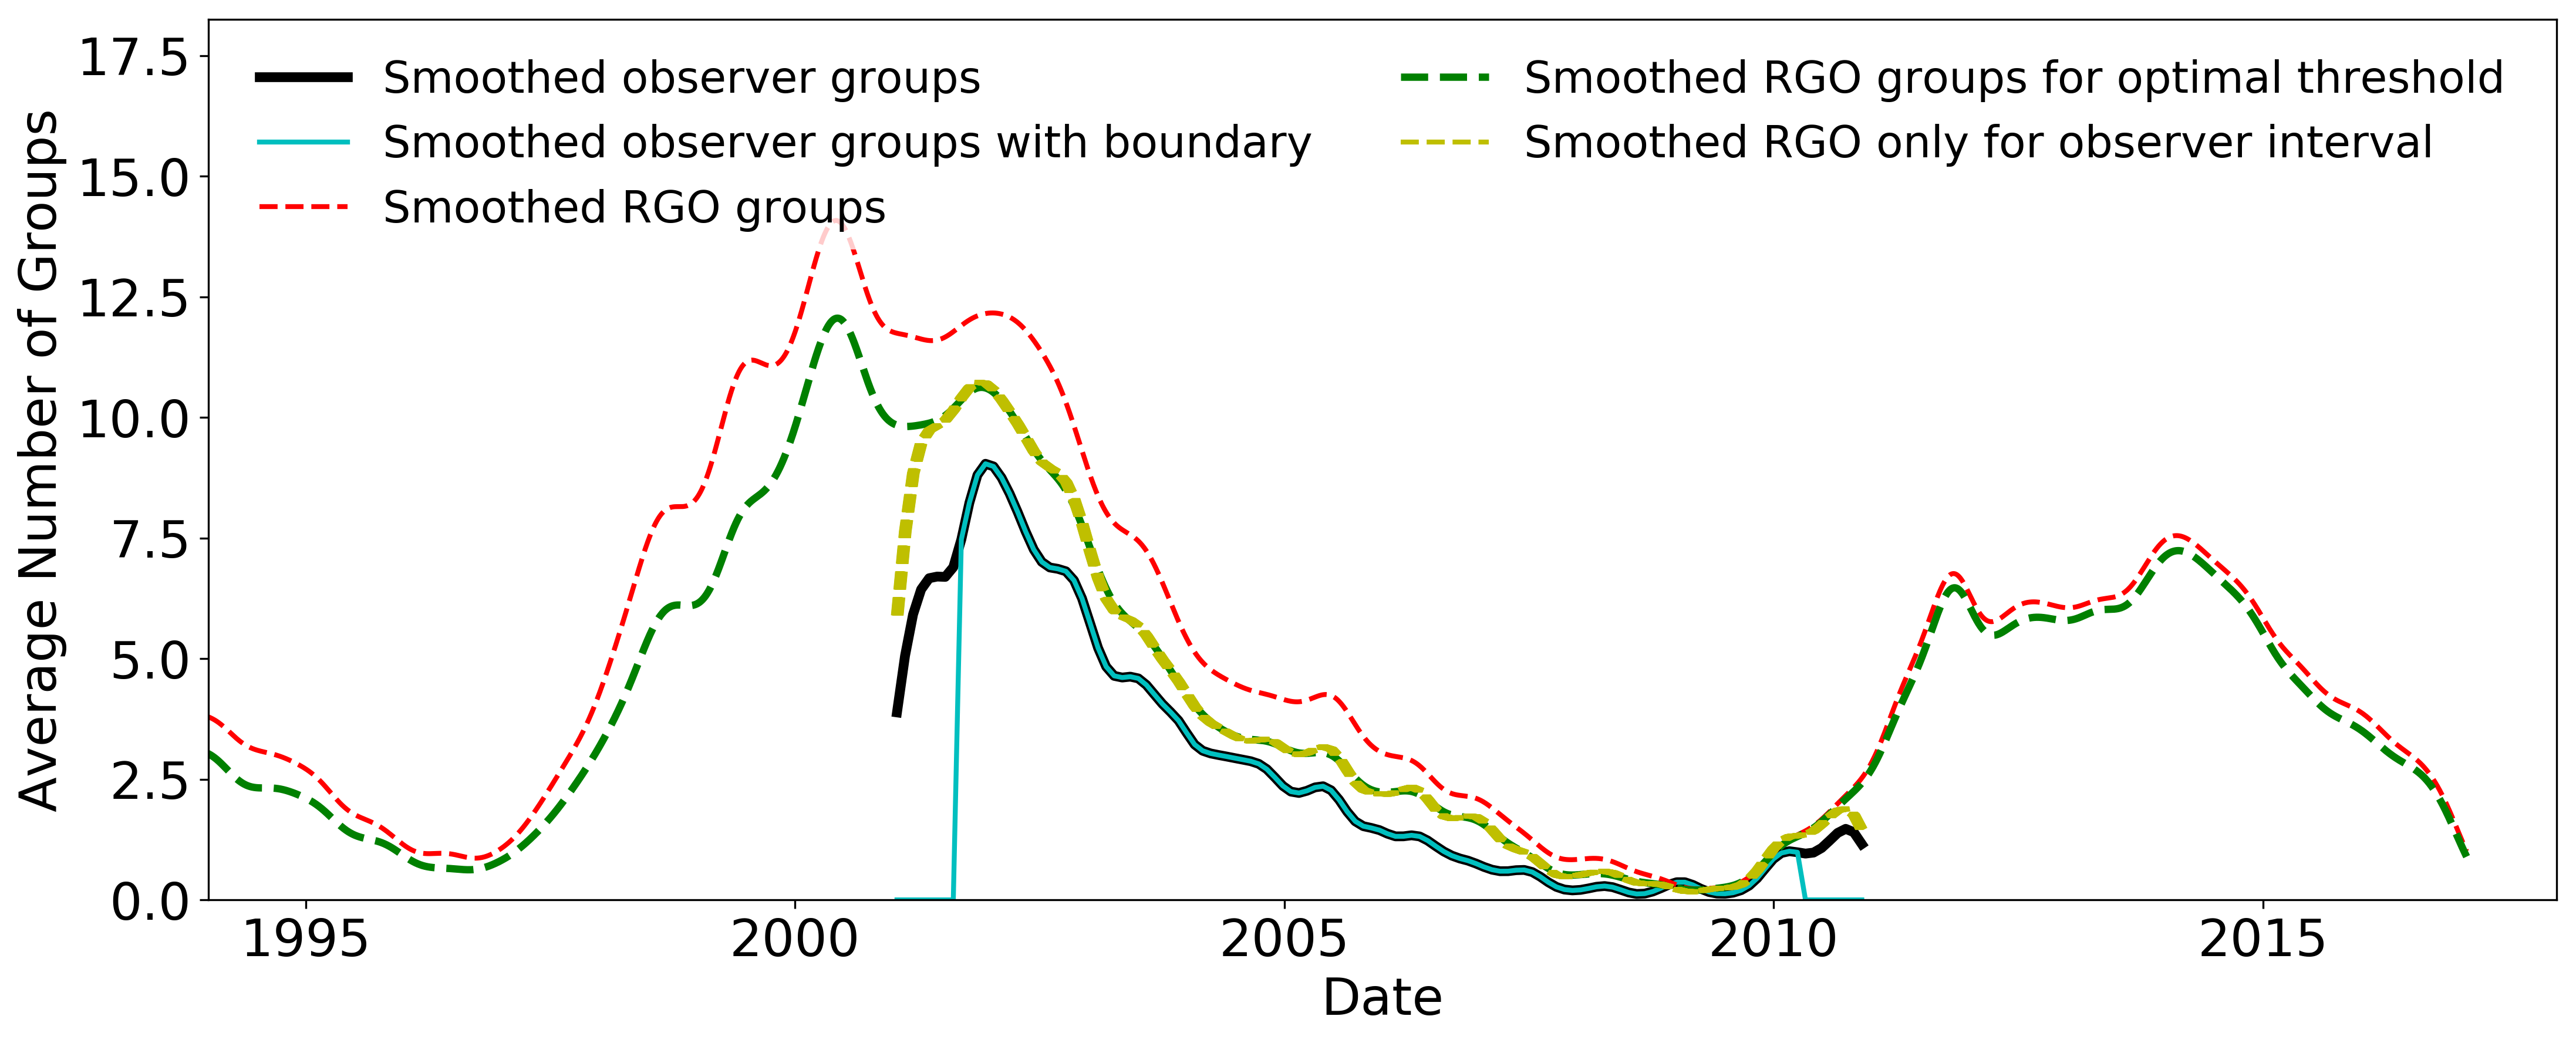

In [32]:
# Size definitions
dpi = 300
pxx = 4000   # Horizontal size of each panel
pxy = 1500   # Vertical size of each panel

nph = 1     # Number of horizontal panels
npv = 1     # Number of vertical panels 

# Padding
padv  = 0  #Vertical padding in pixels
padv2 = 0  #Vertical padding in pixels between panels
padh  = 50 #Horizontal padding in pixels at the edge of the figure
padh2 = 0  #Horizontal padding in pixels between panels

# Figure sizes in pixels
fszv = (npv*pxy + 2*padv + (npv-1)*padv2 )      #Vertical size of figure in inches
fszh = (nph*pxx + 2*padh + (nph-1)*padh2 )      #Horizontal size of figure in inches

# Conversion to relative unites
ppadv  = padv/fszv     #Vertical padding in relative units
ppadv2 = padv2/fszv    #Vertical padding in relative units
ppadh  = padh/fszv     #Horizontal padding the edge of the figure in relative units
ppadh2 = padh2/fszv    #Horizontal padding between panels in relative units


# Calculating number of groups in reference data for given observer threshold
grpsREFth = np.nansum( np.greater(REF_Dat.values[:,3:REF_Dat.values.shape[1]-3],wAv) ,axis = 1).astype(float)
grpsREFth[np.isnan(REF_Dat['AREA1'])] = np.nan
# Smoothing for plotting
Gss_1D_ker = conv.Gaussian1DKernel(75)
grpsREFthsmo  = conv.convolve(grpsREFth,Gss_1D_ker)

# Dataframe for smoothed groups
grpsREFthsmo = pd.DataFrame({"AVGROUPSthsmo": grpsREFthsmo})
newREFgrpthsmo = REF_Grp.join(grpsREFthsmo)

# Dataframe for non-smoothed groups
grpsREFthNOsmo = pd.DataFrame({"AVGROUPSthNOsmo": grpsREFth})
newREFgrpthNOsmo = REF_Grp.join(grpsREFthNOsmo)

datathRGOob = newREFgrpthNOsmo.loc[np.logical_and(newREFgrpthNOsmo['FRACYEAR']>=np.min(ObsDat['FRACYEAR']),newREFgrpthNOsmo['FRACYEAR']<=np.max(ObsDat['FRACYEAR']))]

# Selecting the maximum integer amount of "months" out of the original data and reshaping
yrRGOOb = datathRGOob['FRACYEAR'].values
yrRGOOb = yrRGOOb[0:np.int(yrRGOOb.shape[0]/MoLngt)*MoLngt]
yrRGOOb = yrRGOOb.reshape((-1,MoLngt))

grpsRGOOb = datathRGOob['AVGROUPSthNOsmo'].values
grpsRGOOb = grpsRGOOb[0:np.int(grpsRGOOb.shape[0]/MoLngt)*MoLngt]
grpsRGOOb = grpsRGOOb.reshape((-1,MoLngt))

# Average number of groups
Gss_1D_ker = conv.Gaussian1DKernel(2)
AvGrpRGOOb = conv.convolve(np.nanmean(grpsRGOOb,axis=1),Gss_1D_ker) 
SdGrpRGOOb = np.nanstd(grpsRGOOb,axis=1)

# Observer group number with boundary=None for smoothing
AvGrpObBOU = conv.convolve(np.nanmean(grpsOb,axis=1),Gss_1D_ker,boundary=None)

## Start Figure
fig = plt.figure(figsize=(fszh/dpi,fszv/dpi), dpi = dpi)
ax2 = fig.add_axes([ppadh, ppadv, pxx/fszh, pxy/fszv])

# Plotting Observer
ax2.plot(pltx, AvGrpOb, 'k-', linewidth = 4, alpha = 1) 
ax2.plot(pltx, AvGrpObBOU, 'c-', linewidth = 2, alpha = 1)
# RGO
ax2.plot(REF_Grp['FRACYEAR'], REF_Grp['AVGROUPS'], 'r--', linewidth = 2, alpha = 1) 
ax2.plot(newREFgrpthsmo['FRACYEAR'], newREFgrpthsmo['AVGROUPSthsmo'], 'g--', linewidth = 3, alpha = 1) 
ax2.plot(yrRGOOb, AvGrpRGOOb, 'y--', linewidth = 2, alpha = 1) 

# Axes properties
ax2.set_ylabel('Average Number of Groups')
ax2.set_xlabel('Date')
ax2.set_xlim(left = np.min(datathRGOob['FRACYEAR'])-7, right = np.max(datathRGOob['FRACYEAR'])+7);
ax2.set_ylim(bottom = 0, top = np.max(datathRGOob['AVGROUPS'])*1.5)

ax2.legend(['Smoothed observer groups','Smoothed observer groups with boundary','Smoothed RGO groups','Smoothed RGO groups for optimal threshold','Smoothed RGO only for observer interval'], loc = 'upper center', ncol = 2, frameon = True, edgecolor = 'none', fontsize=18)
